## 1. Objetivo del proyecto:
Se desea conocer el perfil del cliente moroso, para ello se dispone de un conjunto 
de datos, en él podrá encontrar información del crédito (clientes al día y clientes 
morosos), saldos, días de atraso, productos, e información del cliente que solicitó el 
crédito, como su comportamiento con la entidad y el sistema financiero.

## 2. Importar librerias necesarias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_columns', None)  # Para mostrar todas las columnas

In [3]:

# Configura el tamaño de la fuente y el ancho de las columnas
pd.set_option('display.max_colwidth', 1)  # Ajusta el ancho máximo de las columnas
pd.set_option('display.max_rows', 20)       # Muestra como máximo 10 filas
pd.set_option('display.max_columns', 20)    # Muestra como máximo 10 columnas
pd.set_option('display.width', 120)         # Ajusta el ancho total del display

## 3. Importar dataset:

In [4]:
# Importar dataset
df=pd.read_excel('/home/jhayr/Descargas/dataset_caso.xlsx')

In [5]:
# Ver
df.head(5)

ESTADO_CONTABLE  SALCAP_MN  SALCAP_VIG_MN  SALCAP_REG_MN  SALCAP_VEN_MN  SALCAP_JUD_MN  DIAS_ATRASO_CALENDARIO  \
0  1.VIGENTE       74670.62   74670.62       0.0            0.0            0.0            0.0                      
1  1.VIGENTE       1621.46    1621.46        0.0            0.0            0.0            0.0                      
2  1.VIGENTE       4978.68    4978.68        0.0            0.0            0.0            22.0                     
3  1.VIGENTE       11411.64   11411.64       0.0            0.0            0.0            0.0                      
4  1.VIGENTE       421.59     421.59         0.0            0.0            0.0            0.0                      

                                     PRODUCTO       TIPO_CREDITO_SBS  \
0  HIPOTECARIO CAJA PARA CLIENTES              PEQUEÑAS EMPRESAS       
1  ACTIVO FIJO MAQUINARIA Y EQUIPO             PEQUEÑAS EMPRESAS       
2  MICRO: CREDIPUNTUALITO                      MICROEMPRESA            
3  PERSONAL DIRECTO                            CONSUMO NO REVOLVENTE   
4  LINEA DE CREDITO PARA CLIENTE PREFERENCIAL  MICROEMPRESA            

                                          GARANTIAS  ... NUMERO_PAG  MONTO_PAG_CAP_INT DIAS_ATRASO_PAGO_ULT  \
0  BIENES DECLARADOS                                 ...  5.0        2506.93            7.0                   
1  BIENES DECLARADOS, GARANTIAS PERSONALES - AVALES  ...  6.0        293.18             0.0                   
2  BIENES DECLARADOS                                 ...  4.0        712.98             21.0                  
3  BIENES DECLARADOS                                 ...  5.0        595.06             9.0                   
4  NaN                                               ...  1.0        90.26              4.0                   

  FLAG_REPROGRAMADO NRO_REPROGRAMACIONES  FLAG_REFINANCIADO  NRO_REFINANCIACIONES NRO_CRE_CANCELADOS  \
0  0                 0                    0                  0                     8                   
1  0                 0                    0                  0                     0                   
2  0                 0                    0                  0                     2                   
3  0                 0                    0                  0                     2                   
4  0                 0                    0                  0                     9                   

  NRO_CRE_VIG_CLIENTE DIAS_ATRASO_CALENDARIO_MES_SIGUIENTE  
0  2                   0.0                                  
1  1                   0.0                                  
2  1                   22.0                                 
3  1                   0.0                                  
4  6                   0.0                                  

[5 rows x 51 columns]

## 4. Limpieza de datos:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9933 entries, 0 to 9932
Data columns (total 51 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ESTADO_CONTABLE                       9933 non-null   object 
 1   SALCAP_MN                             9933 non-null   float64
 2   SALCAP_VIG_MN                         9933 non-null   float64
 3   SALCAP_REG_MN                         9933 non-null   float64
 4   SALCAP_VEN_MN                         9933 non-null   float64
 5   SALCAP_JUD_MN                         9933 non-null   float64
 6   DIAS_ATRASO_CALENDARIO                9932 non-null   float64
 7   PRODUCTO                              9933 non-null   object 
 8   TIPO_CREDITO_SBS                      9933 non-null   object 
 9   GARANTIAS                             8298 non-null   object 
 10  ESTADO_CIVIL                          9892 non-null   object 
 11  EDAD             

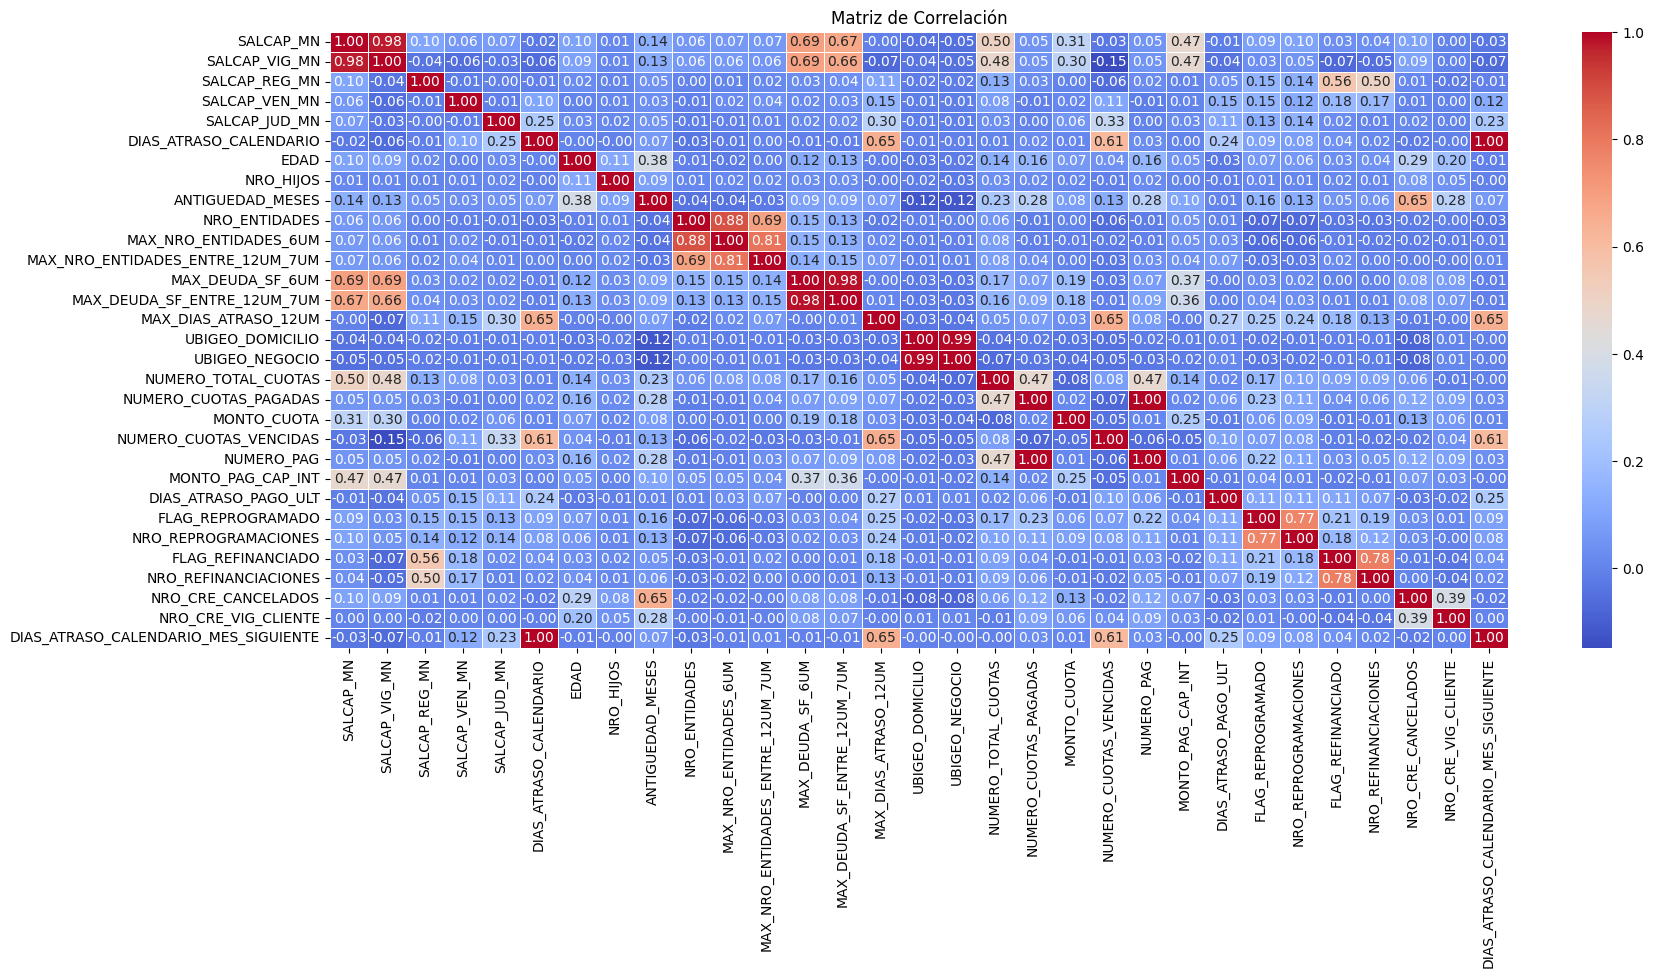

In [7]:
# Identificar las features numericas
features_numericas = df.select_dtypes(include=np.number).columns.tolist()

corr_matrix = df[features_numericas].corr()
# Visualiza la matriz de correlación
plt.figure(figsize=(19, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

In [8]:
# Verificar el largo del dataset
df.shape

(9933, 51)

In [9]:
# Viendo la tabla de correlacion se puede concluir que hay columnas que tienen alta correlación entre si, lo 
#que es equivalente a tener columnas repetidas
# Eliminaré columnas que tenga correlacion mayor a 0.8
columnas_eliminar=['SALCAP_VIG_MN','MAX_NRO_ENTIDADES_6UM','MAX_DEUDA_SF_ENTRE_12UM_7UM','UBIGEO_NEGOCIO',
                   'NUMERO_PAG','DIAS_ATRASO_CALENDARIO_MES_SIGUIENTE']

df.drop(columnas_eliminar,axis=1,inplace=True)

### 4.1. Registros duplicados

In [10]:
# Se verifica que no hay resgistros duplicados
df[df.duplicated()]

Empty DataFrame
Columns: [ESTADO_CONTABLE, SALCAP_MN, SALCAP_REG_MN, SALCAP_VEN_MN, SALCAP_JUD_MN, DIAS_ATRASO_CALENDARIO, PRODUCTO, TIPO_CREDITO_SBS, GARANTIAS, ESTADO_CIVIL, EDAD, ACTIVIDAD_ECONOMICA, SECTOR_ECON, GENERO, NRO_HIJOS, ANTIGUEDAD_MESES, SEGM_MYPE, SEGM_CNS, SEGM_MICRO, CALIFICACION_SBS_MES_ACT, CALIFICACION_SBS_MES_ANT, NRO_ENTIDADES, MAX_NRO_ENTIDADES_ENTRE_12UM_7UM, MAX_DEUDA_SF_6UM, MAX_DIAS_ATRASO_12UM, UBIGEO_DOMICILIO, DPTO_DOMICILIO, PROV_DOMICILIO, DIST_DOMICILIO, DPTO_NEGOCIO, PROV_NEGOCIO, DIST_NEGOCIO, RANGO_MTO_DESEM_MN, NUMERO_TOTAL_CUOTAS, NUMERO_CUOTAS_PAGADAS, MONTO_CUOTA, NUMERO_CUOTAS_VENCIDAS, MONTO_PAG_CAP_INT, DIAS_ATRASO_PAGO_ULT, FLAG_REPROGRAMADO, NRO_REPROGRAMACIONES, FLAG_REFINANCIADO, NRO_REFINANCIACIONES, NRO_CRE_CANCELADOS, NRO_CRE_VIG_CLIENTE]
Index: []

[0 rows x 45 columns]

### 4.2. Tramamiento de tipo de datos

Se verifica que todas las columnas tienen un correcto tipo de datos por el momento.

### 4.3. Tramamiento de valores ausente

El largo del dataset es 9933 registros, se verificará que hacer con cada columna que tenga valores ausentes.

In [11]:
# Obtener una lista de los encabezados que tienen valores ausentes
columnas_con_ausentes1 = df.columns[df.isna().any()].tolist()

#Ver info estadistica de los features numericos con data ausente 
df[columnas_con_ausentes1].describe()

DIAS_ATRASO_CALENDARIO         EDAD    NRO_HIJOS  NRO_ENTIDADES  MAX_NRO_ENTIDADES_ENTRE_12UM_7UM  \
count  9932.000000             9892.000000  9886.000000  9930.000000    9131.000000                        
mean   17.652135               41.192479    0.410075     1.987815       2.038879                           
std    125.826484              12.820639    2.244480     1.044461       1.079593                           
min    0.000000                18.000000    0.000000     1.000000       1.000000                           
25%    0.000000                31.000000    0.000000     1.000000       1.000000                           
50%    0.000000                40.000000    0.000000     2.000000       2.000000                           
75%    0.000000                50.000000    0.000000     3.000000       3.000000                           
max    5462.000000             86.000000    203.000000   8.000000       8.000000                           

       MAX_DEUDA_SF_6UM  MAX_DIAS_ATRASO_12UM  NUMERO_TOTAL_CUOTAS  NUMERO_CUOTAS_PAGADAS  NUMERO_CUOTAS_VENCIDAS  \
count  9.804000e+03      9829.000000           9931.000000          8264.000000            1556.000000              
mean   3.567864e+04      29.432292             19.875843            7.647507               2.911954                 
std    1.219549e+05      108.470255            14.271013            6.951973               3.781401                 
min    1.299000e+01      0.000000              1.000000             1.000000               1.000000                 
25%    5.650688e+03      0.000000              12.000000            3.000000               1.000000                 
50%    1.572964e+04      0.000000              18.000000            6.000000               1.000000                 
75%    4.365760e+04      12.000000             24.000000            11.000000              3.250000                 
max    1.099964e+07      2432.000000           204.000000           105.000000             45.000000                

       DIAS_ATRASO_PAGO_ULT  
count  8264.000000           
mean   2.940586              
std    18.556513             
min   -375.000000            
25%   -1.000000              
50%    0.000000              
75%    4.000000              
max    264.000000

In [12]:
# Obtener el número de valores ausentes en cada columna
valores_ausentes_por_columna = df.isna().sum()

# Filtrar las columnas que tienen valores ausentes
columnas_con_ausentes = valores_ausentes_por_columna[valores_ausentes_por_columna > 0]

print(columnas_con_ausentes.to_string())

DIAS_ATRASO_CALENDARIO              1   
GARANTIAS                           1635
ESTADO_CIVIL                        41  
EDAD                                41  
ACTIVIDAD_ECONOMICA                 815 
GENERO                              41  
NRO_HIJOS                           47  
SEGM_MYPE                           245 
SEGM_CNS                            505 
SEGM_MICRO                          2631
NRO_ENTIDADES                       3   
MAX_NRO_ENTIDADES_ENTRE_12UM_7UM    802 
MAX_DEUDA_SF_6UM                    129 
MAX_DIAS_ATRASO_12UM                104 
DPTO_NEGOCIO                        1888
PROV_NEGOCIO                        1888
DIST_NEGOCIO                        1888
RANGO_MTO_DESEM_MN                  1   
NUMERO_TOTAL_CUOTAS                 2   
NUMERO_CUOTAS_PAGADAS               1669
NUMERO_CUOTAS_VENCIDAS              8377
DIAS_ATRASO_PAGO_ULT                1669


In [13]:
#Borrar los registros de features con menos de 5 VALORES ausentes
df=df.dropna(subset=['DIAS_ATRASO_CALENDARIO'])
df=df.dropna(subset=['NRO_ENTIDADES'])
df=df.dropna(subset=['RANGO_MTO_DESEM_MN'])
df=df.dropna(subset=['NUMERO_TOTAL_CUOTAS'])


#### 4.3.1. Feature Garantias

El feature GARANTIAS tien mas de 1633 valores ausentes, un valor muy alto para eliminar los registros o simplemente imputarle el valor mas repetido.

In [14]:
# Para el caso del feature GARANTIAS, se rellenará de acuerdo a la distrubucion del top 3 del mismo feature,
#para no modificar la distribucion de la variable

# Identifico los valores unicos y su distribución
df['GARANTIAS'].value_counts(dropna=False).sort_values(ascending=False).head(5)

BIENES DECLARADOS                                   6229
NaN                                                 1633
BIENES DECLARADOS, GARANTIAS PERSONALES - AVALES    954 
BIENES DECLARADOS, GARANTIA FONDO FAE 2-98%         283 
DPF                                                 279 
Name: GARANTIAS, dtype: int64

In [15]:
# % deL TOP 3 sin contar los valores nulos
(df['GARANTIAS'].value_counts().sort_values(ascending=False)/(df['GARANTIAS'].notnull().sum())).head(3)

BIENES DECLARADOS                                   0.750934
BIENES DECLARADOS, GARANTIAS PERSONALES - AVALES    0.115009
BIENES DECLARADOS, GARANTIA FONDO FAE 2-98%         0.034117
Name: GARANTIAS, dtype: float64

In [16]:
# Calcular el número de valores ausentes
num_ausentes_garantias = df['GARANTIAS'].isnull().sum()

# Definir la distribución de valores de relleno
valores_relleno_garantias = ['BIENES DECLARADOS'] * int(0.75 * num_ausentes_garantias) + ['BIENES DECLARADOS, GARANTIAS PERSONALES - AVALES'] * int(0.15 * num_ausentes_garantias) + ['BIENES DECLARADOS, GARANTIA FONDO FAE 2-98%'] * int(0.2 * num_ausentes_garantias)

if num_ausentes_garantias <= len(valores_relleno_garantias):
    # Recortar la lista al azar para que tenga m elementos
    valores_relleno_garantias = random.sample(valores_relleno_garantias, num_ausentes_garantias)

# Asignar aleatoriamente los valores de relleno a los valores ausentes
random.shuffle(valores_relleno_garantias)
df.loc[df['GARANTIAS'].isnull(), 'GARANTIAS'] = valores_relleno_garantias

#### 4.3.2. Feature estado civil y genero

In [17]:
# Ver la distribucion de los valores 
df['ESTADO_CIVIL'].value_counts(dropna=False)

SOLTERO        6410
CONVIVIENTE    1886
CASADO         1051
SEPARADO       282 
VIUDO          147 
DIVORCIADO     111 
NaN            41  
Name: ESTADO_CIVIL, dtype: int64

In [18]:
# En este caso optaré por rellenar con el valor mas repetido = SOLTERO
df['ESTADO_CIVIL'].fillna('SOLTERO',inplace=True)

In [19]:
# Para el caso de GENERO, rellenaré los valores ausentes siguiendo la distribución de los otros dos valores
df['GENERO'].value_counts(dropna=False)

M      5053
F      4834
NaN    41  
Name: GENERO, dtype: int64

In [20]:
# Definir la distribución de valores de relleno
valores_relleno_genero = ['M'] * int(0.515 * 41) + ['F'] * int(0.49 * 41) 

if 41 <= len(valores_relleno_genero):
    # Recortar la lista al azar para que tenga m elementos
    valores_relleno_genero = random.sample(valores_relleno_genero, 41)

# Asignar aleatoriamente los valores de relleno a los valores ausentes
random.shuffle(valores_relleno_garantias)
df.loc[df['GENERO'].isnull(), 'GENERO'] = valores_relleno_genero

#### 4.3.3. Feature EDAD, NRO_HIJOS, NUMERO_CUOTAS_PAGADAS y	NUMERO_CUOTAS_VENCIDAS

In [21]:
# Distribución de los siguientes features:
df[['EDAD','NRO_HIJOS' ,'NUMERO_CUOTAS_PAGADAS', 'NUMERO_CUOTAS_VENCIDAS']].describe()

EDAD    NRO_HIJOS  NUMERO_CUOTAS_PAGADAS  NUMERO_CUOTAS_VENCIDAS
count  9887.000000  9881.000000  8261.000000            1553.000000           
mean   41.189542    0.410282     7.642779               2.860914              
std    12.820319    2.245029     6.948242               3.548990              
min    18.000000    0.000000     1.000000               1.000000              
25%    31.000000    0.000000     3.000000               1.000000              
50%    40.000000    0.000000     6.000000               1.000000              
75%    50.000000    0.000000     11.000000              3.000000              
max    86.000000    203.000000   105.000000             41.000000

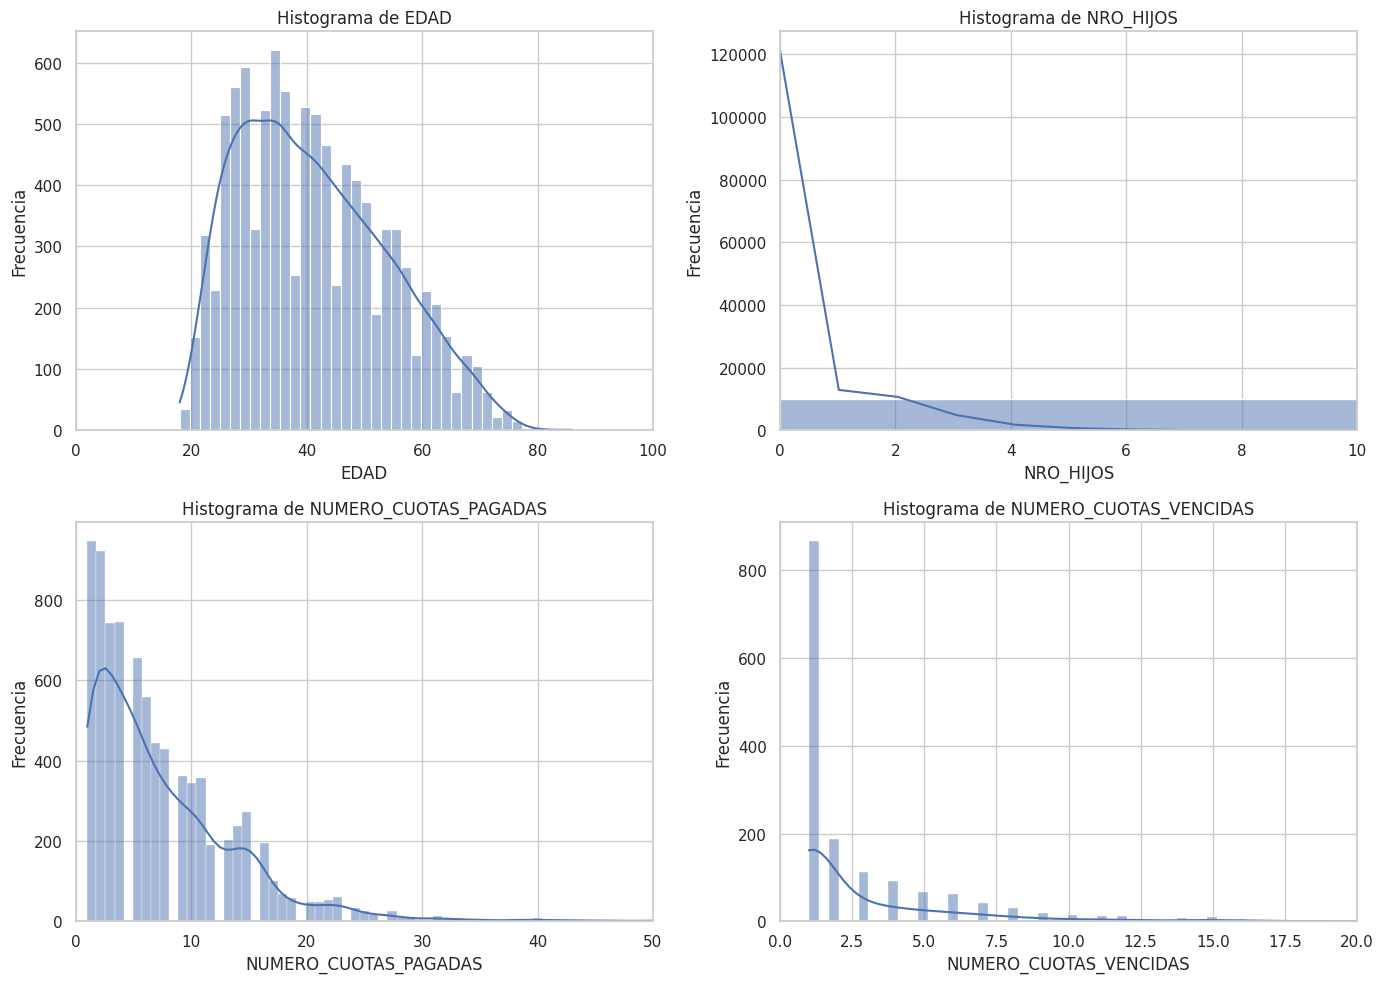

In [22]:
# Crear histogramas para tener una vision más amplia
sns.set(style="whitegrid")

# Definir los límites del eje x para cada histograma
x_limits = {
    'EDAD': (0, 100),
    'NRO_HIJOS': (0, 10),
    'NUMERO_CUOTAS_PAGADAS': (0, 50),
    'NUMERO_CUOTAS_VENCIDAS': (0, 20)
}

# Dar la forma de 2 y 2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Lista de variables para los histogramas
variables = ['EDAD', 'NRO_HIJOS', 'NUMERO_CUOTAS_PAGADAS', 'NUMERO_CUOTAS_VENCIDAS']

# Iterar 
for ax, variable in zip(axes.flatten(), variables):
    sns.histplot(df[variable], kde=True, ax=ax)
    ax.set_title(f'Histograma de {variable}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Frecuencia')
    # Establecer límites personalizados del eje x 
    if variable in x_limits:
        ax.set_xlim(x_limits[variable])

plt.tight_layout()
plt.show()

In [23]:
# En el caso de la edad, se rellenará los valores ausenten con la mediana
mediana_edad=df['EDAD'].median()
df['EDAD'].fillna(mediana_edad, inplace=True)

# En el caso de numero de hijos lo rellenaré con la mediana
mediana_hijos=df['NRO_HIJOS'].median()
df['NRO_HIJOS'].fillna(mediana_hijos, inplace=True)

In [24]:
# En el caso de NUMERO_CUOTAS_PAGADAS descubrí que si MONTO_PAG_CAP_INT = 0, el numero de cuotas pagadas también es cero, por lo tanto:
df.loc[(df['MONTO_PAG_CAP_INT'] == 0) & (df['NUMERO_CUOTAS_PAGADAS'].isnull()), 'NUMERO_CUOTAS_PAGADAS'] = 0

# Sigue habinedno valores nulos en NUMERO_CUOTAS_PAGADAS, vemos que el monto de cuota es mayor que MONTO_PAG_CAP_INT
# significa que se ha pagado una cuota (incompleta), por lo tanto rellenaré los nulos con 1
df['NUMERO_CUOTAS_PAGADAS'].fillna(1,inplace=True)

In [25]:
# En el caso de NUMERO_CUOTAS_VENCIDAS es una buena estimación calcularla como la resta entre NUMERO_TOTAL_CUOTAS - NUMERO_CUOTAS_PAGADAS
df.loc[df['NUMERO_CUOTAS_VENCIDAS'].isnull(), 'NUMERO_CUOTAS_VENCIDAS'] = df['NUMERO_TOTAL_CUOTAS'] - df['NUMERO_CUOTAS_PAGADAS']



#### 4.3.4. Features ACTIVIDAD_ECONOMICA, SEGM_MICRO , SEGM_CNS, SEGM_MYPE 

In [26]:
# Ver ACTIVIDAD_ECONOMICA
df['ACTIVIDAD_ECONOMICA'].value_counts(dropna=False).sort_values(ascending=False).head(15)

NaN                                                             814
COMIDAS PREPARADAS (RESTAURANTES-SANDWICHERIAS-DULCERIAS, CA    362
ABARROTES                                                       338
CONSTRUCCION                                                    320
PRESTACION DE SERVICIOS PROFESIONALES                           302
OTRAS ACTIVIDADES DE TIPO SERVICIO N.C.P.                       297
SERVICIOS DE MOZOS DE CUADRA, CHOFERES, CONSERJES, INSTITUTR    287
OTRAS ACTIVIDADES DE SERVICIOS                                  279
VENTA AL POR MENOR DE ANIMALES CASEROS                          254
OTROS TIPOS DE TRANSPORTE REGULAR DE PASAJEROS POR VIA TERRE    240
SERVICIO REGULAR DE TRANSPORTE URBANO                           215
ACTIVIDADES DE ALQUILER DE INMUEBLES A CAMBIO DE UNA RETRIBU    202
VENTA AL POR MENOR DE FRUTAS Y VERDURAS-VERDULERIA Y FRUTERI    173
VENTA AL POR MENOR PREFERENTEMENTE DE ALIMENTOS O VIVERES- B    166
VENTA AL POR MENOR DE PRENDAS DE VESTIR, REGALOS

In [27]:
# Debido a que hay muchas categorias optaré por crear una categoria llamada OTROS para rellenar los valores ausentes
df['ACTIVIDAD_ECONOMICA'].fillna('OTROS',inplace=True)

In [28]:
# Ver SEGM_MICRO
df['SEGM_MICRO'].value_counts()/(df['SEGM_MICRO'].notnull().sum())

PREFERENTE      0.400493
PREMIUM         0.279551
NUEVO           0.204356
PREFERENCIAL    0.066840
RECURRENTE      0.048760
Name: SEGM_MICRO, dtype: float64

In [29]:
# Debido a que en el caso de SEGM_MICRO no hay muchos valores diferentes, calcularé el % del top 3 y rellenare los
# valores ausentes con el mismo % obtenido con el fin de no varias la distribución de este feature

# Calcular el número de valores ausentes
num_ausentes_SEGM_MICRO = df['SEGM_MICRO'].isnull().sum()

# Definir la distribución de valores de relleno
valores_relleno_SEGM_MICRO = ['PREFERENTE'] * int(0.45 * num_ausentes_SEGM_MICRO) + ['PREMIUM'] * int(0.305 * num_ausentes_SEGM_MICRO) + ['NUEVO'] * int(0.25 * num_ausentes_SEGM_MICRO)

if num_ausentes_SEGM_MICRO <= len(valores_relleno_SEGM_MICRO):
    # Recortar la lista al azar para que tenga m elementos
    valores_relleno_SEGM_MICRO = random.sample(valores_relleno_SEGM_MICRO, num_ausentes_SEGM_MICRO)

# Asignar aleatoriamente los valores de relleno a los valores ausentes
random.shuffle(valores_relleno_SEGM_MICRO)
df.loc[df['SEGM_MICRO'].isnull(), 'SEGM_MICRO'] = valores_relleno_SEGM_MICRO

In [30]:
# Ver SEGM_CNS

# Crear tabla de contigencia entre  SEGM_CNS y  SEGM_MICRO
print(pd.crosstab(df['SEGM_CNS'], df['SEGM_MICRO']))
print()
# ver SEGM_CNS
df['SEGM_CNS'].value_counts(dropna=False)

SEGM_MICRO           NUEVO  PREFERENCIAL  PREFERENTE  PREMIUM  RECURRENTE
SEGM_CNS                                                                 
PERS NUEVO           637    4             277         64       39        
PERS PREFERENCIAL A  213    315           412         446      16        
PERS PREFERENCIAL B  246    91            718         150      260       
PERS PREFERENTE      49     4             330         26       0         
PERS PREMIUM         76     33            617         1342     0         
PERS RECURRENTE      813    39            1514        651      41        



PERS RECURRENTE        3058
PERS PREMIUM           2068
PERS PREFERENCIAL B    1465
PERS PREFERENCIAL A    1402
PERS NUEVO             1021
NaN                    505 
PERS PREFERENTE        409 
Name: SEGM_CNS, dtype: int64

In [31]:
# Como se puede ver en la tabla de contingencia de arriba. hay cierta relacion coherente entre SEGM_MICRO y SEGM_CNS de la sgt manera:
#SEGM_MICRO      SEGM_CNS

#NUEVO           PERS RECURRENTE
#PREFERENCIAL    PERS PREFERENCIAL A	
#PREFERENTE      PERS RECURRENTE
#PREMIUM         PERS PREMIUM
#RECURRENTE      PERS PREFERENCIAL B

# Aplicar los cambios
df.loc[(df['SEGM_MICRO'] == 'NUEVO') & (df['SEGM_CNS'].isnull()), 'SEGM_CNS'] = 'PERS RECURRENTE'
df.loc[(df['SEGM_MICRO'] == 'PREFERENCIAL') & (df['SEGM_CNS'].isnull()), 'SEGM_CNS'] = 'PERS PREFERENCIAL A'
df.loc[(df['SEGM_MICRO'] == 'PREFERENTE') & (df['SEGM_CNS'].isnull()), 'SEGM_CNS'] = 'PERS RECURRENTE'
df.loc[(df['SEGM_MICRO'] == 'PREMIUM') & (df['SEGM_CNS'].isnull()), 'SEGM_CNS'] = 'PERS PREMIUM'
df.loc[(df['SEGM_MICRO'] == 'RECURRENTE') & (df['SEGM_CNS'].isnull()), 'SEGM_CNS'] = 'PERS PREFERENCIAL B'

In [32]:
# Ver SEGM_MYPE
print(pd.crosstab(df['SEGM_CNS'], df['SEGM_MYPE']))
print()
df['SEGM_MYPE'].value_counts(dropna=False)

SEGM_MYPE            BRONCE  NUEVO  NUEVO BRONCE  NUEVO ORO  NUEVO PLATA  PREFERENCIAL BRONCE  PREFERENCIAL ORO  \
SEGM_CNS                                                                                                          
PERS NUEVO           20      765    70            53         97           3                    5                  
PERS PREFERENCIAL A  72      213    29            15         23           111                  421                
PERS PREFERENCIAL B  268     280    44            27         62           328                  122                
PERS PREFERENTE      13      146    21            56         141          8                    7                  
PERS PREMIUM         109     340    19            18         21           38                   206                
PERS RECURRENTE      1943    632    21            8          15           123                  137                

SEGM_MYPE            PREFERENCIAL PLATA  PREMIUM BRONCE  PREMIUM ORO  PREMIUM P

BRONCE                 2425
NUEVO                  2376
PREFERENCIAL ORO       898 
PREMIUM PLATA          841 
PREMIUM BRONCE         643 
PREMIUM ORO            623 
PREFERENCIAL BRONCE    611 
PREFERENCIAL PLATA     526 
NUEVO PLATA            359 
NaN                    245 
NUEVO BRONCE           204 
NUEVO ORO              177 
Name: SEGM_MYPE, dtype: int64

In [33]:
# Como se puede ver en la tabla de contingencia de arriba. hay cierta relacion coherente entre SEGM_CNS y SEGM_MYPE de la sgt manera:
#  SEGM_CNS            SEGM_MYPE

#PERS RECURRENTE       BRONCE
#PERS NUEVO            NUEVO
#PERS NUEVO             NUEVO BRONCE
#PERS PREFERENTE      NUEVO ORO
#PERS PREFERENTE      NUEVO PLATA
#PERS PREFERENCIAL B  PREFERENCIAL BRONCE
#PERS PREFERENCIAL A  PREFERENCIAL ORO
#PERS PREFERENCIAL A   PREFERENCIAL PLATA
#PERS PREMIUM          PREMIUM BRONCE
#PERS PREMIUM          PREMIUM ORO
#PERS PREMIUM          PREMIUM PLATA

# Aplicar los cambios
df.loc[(df['SEGM_CNS'] == 'PERS RECURRENTE') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'BRONCE'
df.loc[(df['SEGM_CNS'] == 'PERS NUEVO') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'NUEVO'
df.loc[(df['SEGM_CNS'] == 'PERS NUEVO') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'NUEVO BRONCE'
df.loc[(df['SEGM_CNS'] == 'PERS PREFERENTE') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'NUEVO ORO'
df.loc[(df['SEGM_CNS'] == 'PERS PREFERENTE') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'NUEVO PLATA'
df.loc[(df['SEGM_CNS'] == 'PERS PREFERENCIAL B') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREFERENCIAL BRONCE'
df.loc[(df['SEGM_CNS'] == 'PERS PREFERENCIAL A') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREFERENCIAL ORO'
df.loc[(df['SEGM_CNS'] == 'PERS PREFERENCIAL A') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREFERENCIAL PLATA'
df.loc[(df['SEGM_CNS'] == 'PERS PREMIUM') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREMIUM BRONCE'
df.loc[(df['SEGM_CNS'] == 'PERS PREMIUM') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREMIUM ORO'
df.loc[(df['SEGM_CNS'] == 'PERS PREMIUM') & (df['SEGM_MYPE'].isnull()), 'SEGM_MYPE'] = 'PREMIUM PLATA'

#### 4.3.5. Features DPTO_NEGOCIO, PROV_NEGOCIO, DIST_NEGOCIO

In [34]:
# En este caso optaré por eliminar esos 3 features porque en su lugar es sufieciente trabajar con DPTO_DOMICILIO ya que este
# no tiene valores ausentes y hay una gran similitud entre DPTO_DOMICILIO y DPTO_NEGOCIO
df.drop(['DPTO_NEGOCIO','PROV_NEGOCIO','DIST_NEGOCIO'], axis=1, inplace=True)



#### 4.3.6. Features DIAS_ATRASO_PAGO_ULT 

In [35]:
# En el caso de DIAS_ATRASO_PAGO_ULT es razonable pensar que si MAX_DIAS_ATRASO_12UM es 0 entonces DIAS_ATRASO_PAGO_ULT es tambien 0
df.loc[(df['MAX_DIAS_ATRASO_12UM'] == 0) & (df['DIAS_ATRASO_PAGO_ULT'].isnull()), 'DIAS_ATRASO_PAGO_ULT'] = 0

In [36]:
# el resto lo rellenaré con la data de DIAS_ATRASO_CALENDARIO
df['DIAS_ATRASO_PAGO_ULT'].fillna(df['DIAS_ATRASO_CALENDARIO'], inplace=True)

In [37]:
df[['DIAS_ATRASO_CALENDARIO','DIAS_ATRASO_PAGO_ULT']].describe()

DIAS_ATRASO_CALENDARIO  DIAS_ATRASO_PAGO_ULT
count  9928.000000             9928.000000         
mean   16.788074               5.138396            
std    116.633591              36.300587           
min    0.000000               -375.000000          
25%    0.000000                0.000000            
50%    0.000000                0.000000            
75%    0.000000                3.000000            
max    5462.000000             1251.000000

#### 4.3.7. Features MAX_NRO_ENTIDADES_ENTRE_12UM_7UM, MAX_DEUDA_SF_6UM,MAX_DIAS_ATRASO_12UM

In [38]:
# Ver MAX_NRO_ENTIDADES_ENTRE_12UM_7UM
df['MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'].describe()

count    9127.000000
mean     2.039224   
std      1.079665   
min      1.000000   
25%      1.000000   
50%      2.000000   
75%      3.000000   
max      8.000000   
Name: MAX_NRO_ENTIDADES_ENTRE_12UM_7UM, dtype: float64

In [39]:
# Rellenaré los valores de MAX_NRO_ENTIDADES_ENTRE_12UM_7UM con su media siempre y cuando NRO_ENTIDADES sea menor que dicha media
df.loc[(df['NRO_ENTIDADES'] <= df['MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'].median()) & (df['MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'].isnull()), 'MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'] = df['MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'].median()

# Caso contratio rellenare los valores ausentes de MAX_NRO_ENTIDADES_ENTRE_12UM_7UM con el valor de NRO_ENTIDADES  
df['MAX_NRO_ENTIDADES_ENTRE_12UM_7UM'].fillna(df['NRO_ENTIDADES'], inplace=True)

In [40]:
# Ver MAX_DIAS_ATRASO_12UM
print(df['MAX_DIAS_ATRASO_12UM'].describe())

# Para el caso de MAX_DIAS_ATRASO_12UM  rellenare sus valores ausentes  con DIAS_ATRASO_CALENDARIO
df['MAX_DIAS_ATRASO_12UM'].fillna(df['DIAS_ATRASO_CALENDARIO'], inplace=True)





count    9825.000000
mean     28.932112  
std      103.494232 
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      12.000000  
max      2283.000000
Name: MAX_DIAS_ATRASO_12UM, dtype: float64


In [41]:
# Ver MAX_DEUDA_SF_6UM
print(df[['MAX_DEUDA_SF_6UM','SALCAP_MN']].describe())

# Rellenaré los datos ausentes de MAX_DEUDA_SF_6UM con SALCAP_MN
df['MAX_DEUDA_SF_6UM'].fillna(df['SALCAP_MN'], inplace=True)

       MAX_DEUDA_SF_6UM     SALCAP_MN
count  9.801000e+03      9.928000e+03
mean   3.568340e+04      1.152123e+04
std    1.219730e+05      2.335370e+04
min    1.299000e+01      0.000000e+00
25%    5.648670e+03      1.392053e+03
50%    1.573135e+04      4.000000e+03
75%    4.366620e+04      1.313360e+04
max    1.099964e+07      1.262295e+06


In [42]:
print(df[['MAX_DEUDA_SF_6UM','SALCAP_MN']].describe())

       MAX_DEUDA_SF_6UM     SALCAP_MN
count  9.928000e+03      9.928000e+03
mean   3.527569e+04      1.152123e+04
std    1.212448e+05      2.335370e+04
min    1.299000e+01      0.000000e+00
25%    5.427485e+03      1.392053e+03
50%    1.541935e+04      4.000000e+03
75%    4.301335e+04      1.313360e+04
max    1.099964e+07      1.262295e+06


### 4.4. Outliers

In [43]:
# Funcion para crear boxplot mas rápido
def generar_boxplot(df, columna, figsize=(8, 6)):
    # Datos para el boxplot
    data = df[columna]

    # Crear el boxplot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(data, vert=True, patch_artist=True, showfliers=True)

    # Calcular los valores de los bigotes
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr
    lower_whisker = q1 - 1.5 * iqr
    upper_whisker = min(upper_whisker, data[data <= upper_whisker].max())
    lower_whisker = max(lower_whisker, data[data >= lower_whisker].min())

    # Añadir líneas para marcar los bigotes
    ax.plot([1, 1], [lower_whisker, upper_whisker], color='black', linestyle='-', linewidth=1)

    # Añadir anotaciones con los valores de los bigotes
    ax.text(1.05, upper_whisker, f'{upper_whisker:.2f}', verticalalignment='center')
    ax.text(1.05, lower_whisker, f'{lower_whisker:.2f}', verticalalignment='center')

    # Ajustar los límites del gráfico
    ax.set_ylim([data.min() - iqr, data.max() + iqr])

    # Ajustar títulos y etiquetas
    ax.set_title(f'Boxplot de {columna}')
    ax.set_ylabel('Valor')

    # Mostrar
    plt.show()

In [44]:
# Para el caso de el numero de hijos, como se puede ver en el histograma de arriba, tener 5 a + hijos
#es muy fuera de lo comun por eso borrare todos los registros que cumplan con eso
df=df.query('NRO_HIJOS < 5')

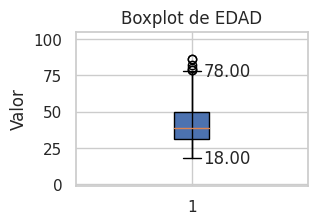

None


In [45]:
# Para el caso de la edad eliminaré todos lo valores mayores a 78
print(generar_boxplot(df, 'EDAD', figsize=(3, 2)))

df=df.query('EDAD <=78')

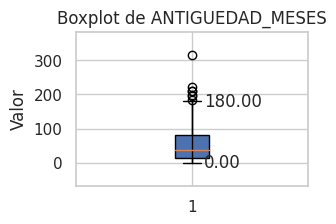

None


In [46]:
# Para el caso de antiguedad de meses eliminaré los valores por encima de 250
print(generar_boxplot(df, 'ANTIGUEDAD_MESES', figsize=(3, 2)))
df=df.query('ANTIGUEDAD_MESES < 250')

## 5. EDA:

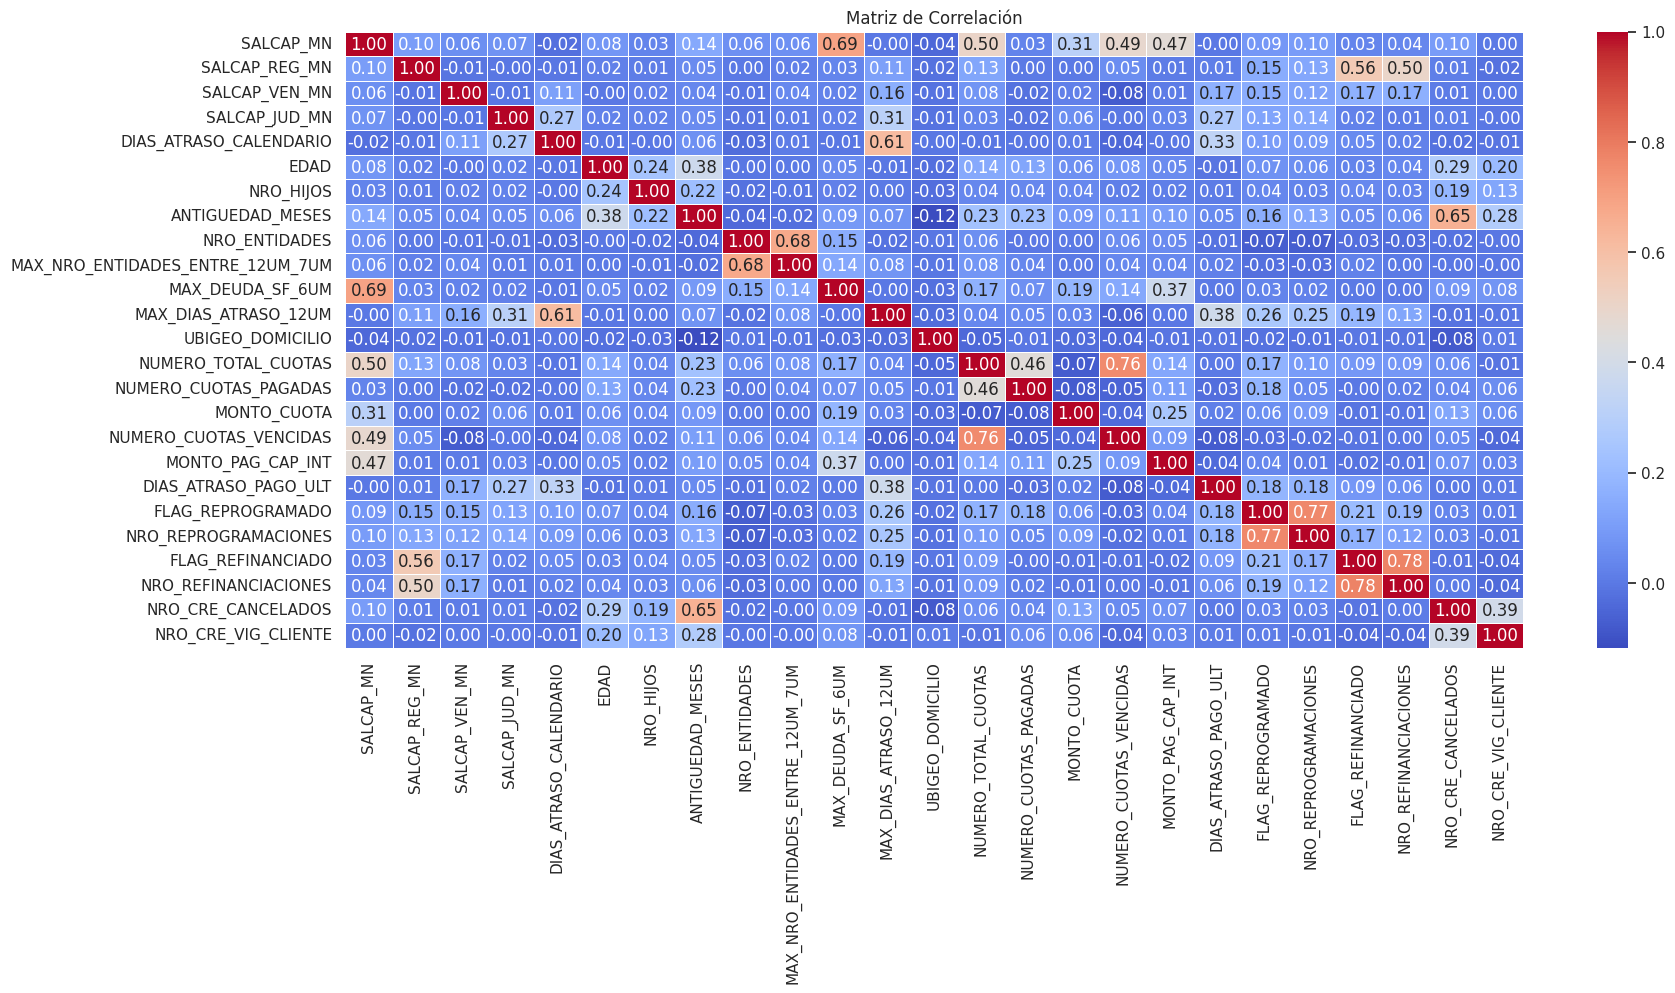

In [47]:
# Ejecuto un analisis multivariable con ayuda de una matriz de correlación

features_numericas = df.select_dtypes(include=np.number).columns.tolist()

corr_matrix = df[features_numericas].corr()
# Visualiza la matriz de correlación
plt.figure(figsize=(19, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title("Matriz de Correlación")
plt.show()

**Ya no hay variables con fuerte correlación entre si**

## 5.1. Identificar a los clientes morosos

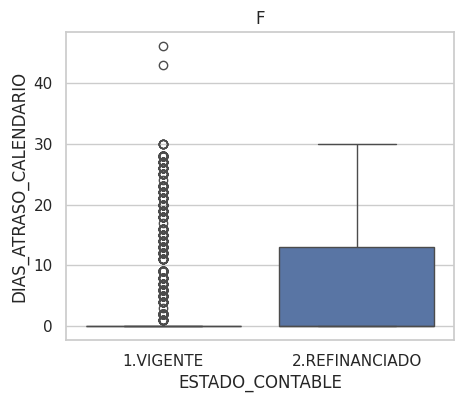

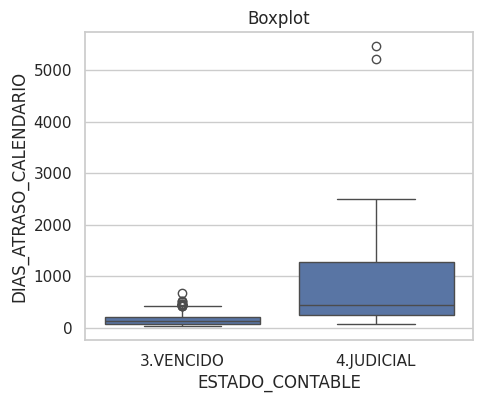

In [48]:
# Segun mi experiencia el feature que identifica que cliente es moroso esta entre ESTADO_CONTABLE y  DIAS_ATRASO_CALENDARIO

# Boxplot 
plt.figure(figsize=(5, 4))
sns.boxplot(x='ESTADO_CONTABLE', y='DIAS_ATRASO_CALENDARIO', data=df.query('ESTADO_CONTABLE in ["1.VIGENTE","2.REFINANCIADO"]'))
plt.title('F')
plt.show()
print()
plt.figure(figsize=(5, 4))
sns.boxplot(x='ESTADO_CONTABLE', y='DIAS_ATRASO_CALENDARIO', data=df.query('ESTADO_CONTABLE in ["4.JUDICIAL","3.VENCIDO"]'))
plt.title('Boxplot')
plt.show()

Se puede ver como cuando es estado contable es Vigente y Refinanciado los dias de atraso calendario suele ser menor a 30 dias, pero cuando el estado contable es Vencido o Judicial los dias de atraso calendario estan por encima de 30 dias.

In [49]:
# Al parecer los clientes que tengan DIAS_ATRASO_CALENDARIO <= 30 no son morosos o los clientes que estan con estado contable  1.VIGENTE o 2.REFINANCIADO
# tampoco lo son , vamos a confirmarlo

# Armo una tabla de contingencia agrupada para verificar
pd.crosstab(df['DIAS_ATRASO_CALENDARIO'].apply(lambda x:'mayor a 30' if x >30 else 'menor_igual a 30'), df['ESTADO_CONTABLE'])

ESTADO_CONTABLE         1.VIGENTE  2.REFINANCIADO  3.VENCIDO  4.JUDICIAL
DIAS_ATRASO_CALENDARIO                                                  
mayor a 30              2          0               674        59        
menor_igual a 30        8962       155             0          0

Se concluye que los clientes morosos tienen DIAS_ATRASO_CALENDARIO mayor a 30 y que esos dos registros que tienen estado contable vigente pero con  mas de 30 dias de atraso son **outliers**.  
Medidas a tomas:  
1. Eliminar esos dos registros.
2. Crear un feature llamado ESTADO_MOROSO donde 1 significará que si es moroso  y 0 que no lo es 

In [50]:
# Eliminar los outliers
df = df[~((df['DIAS_ATRASO_CALENDARIO'] > 30) & (df['ESTADO_CONTABLE'] == '1.VIGENTE'))]

# Crear nuevo feature ESTADO_MOROSO donde 1 significará que si es moroso y 0 que no lo es
df['ESTADO_MOROSO']= df['DIAS_ATRASO_CALENDARIO'].apply(lambda x: 1 if x>30 else 0)


## 5.2. Ver relaciones entre algunas variables

In [51]:
def plot_catplot(x, y, hue, data, height=5, aspect=2, ylim=(0, 800)):
    # Creando el gráfico
    g = sns.catplot(x=x, y=y, hue=hue, data=data, height=height, aspect=aspect)

    # Rotando las etiquetas del eje X
    g.set_xticklabels(rotation=90)

    # Ajustar el tamaño de la fuente de las etiquetas del eje
    plt.setp(g.ax.get_xticklabels(), fontsize=8)
    plt.setp(g.ax.get_yticklabels(), fontsize=8)

    # Ajustando el tamaño de la leyenda
    g.ax.legend(fontsize='small', title_fontsize='medium')

    # Establecer límite  eje Y
    g.set(ylim=ylim)

    # Mostrar 
    plt.show()

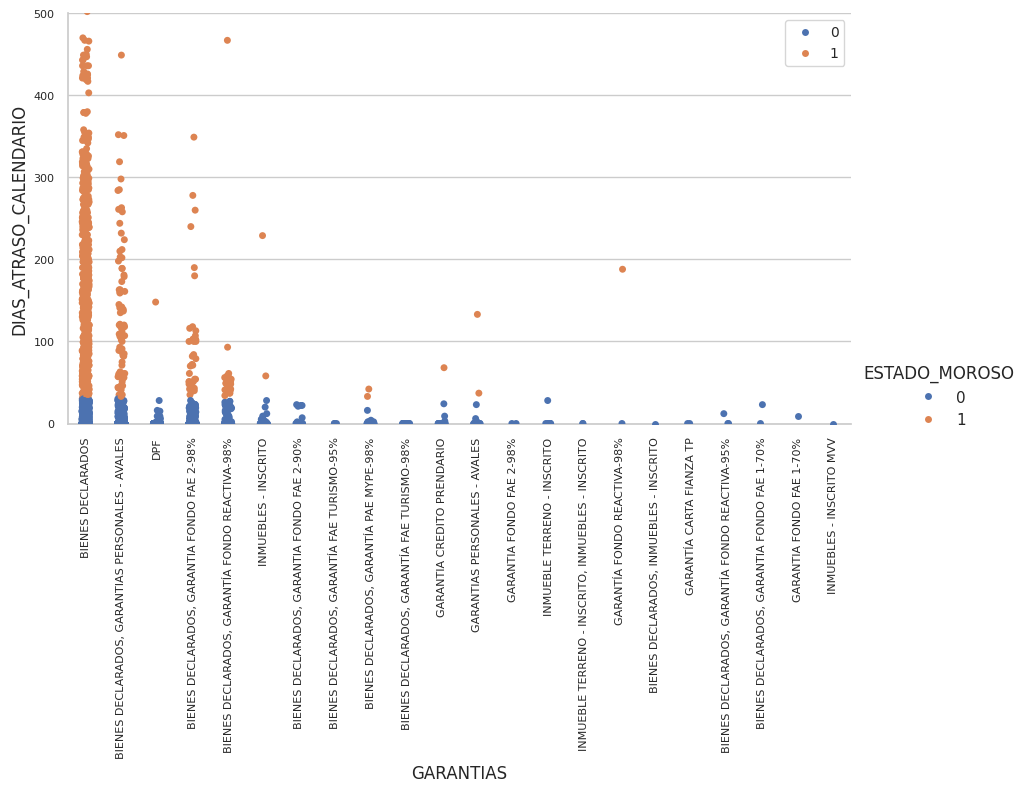

In [88]:
# Relacion entre  ("GARANTIAS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO")
plot_catplot("GARANTIAS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=2, ylim=(0, 500))

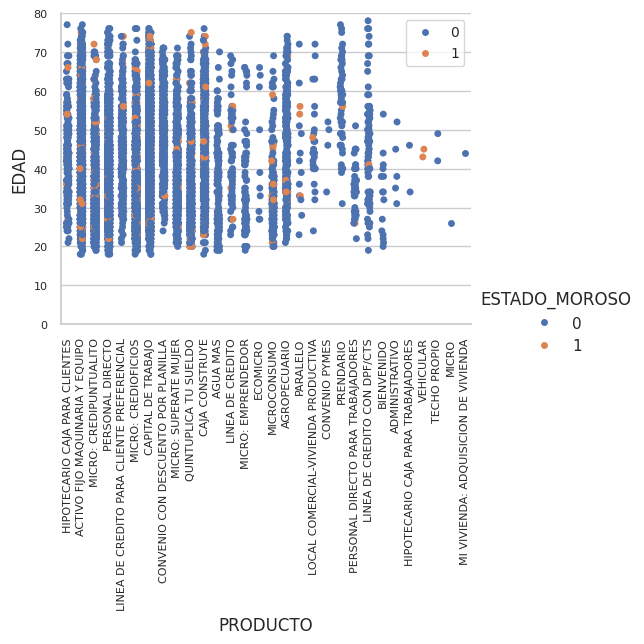

In [53]:
#Relación entre producto y edad
plot_catplot("PRODUCTO", "EDAD", "ESTADO_MOROSO", df, height=4, aspect=1.5, ylim=(0,80 ))

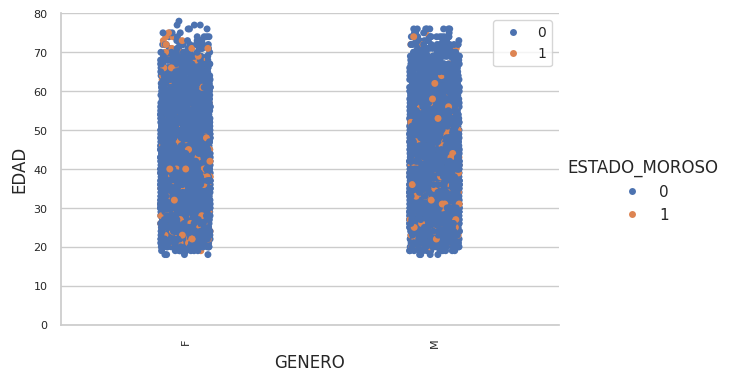

In [54]:
#Relación entre genero y edad
plot_catplot("GENERO", "EDAD", "ESTADO_MOROSO", df, height=4, aspect=1.5, ylim=(0,80 ))

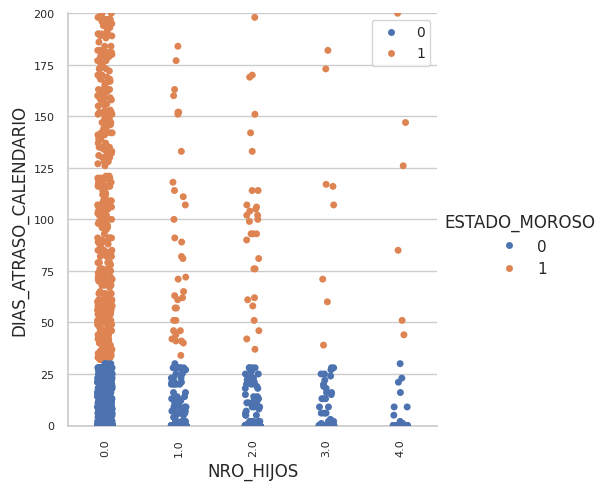

In [89]:
#Relación entre numero de hijos y dias de atraso
plot_catplot("NRO_HIJOS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1, ylim=(0,200 ))

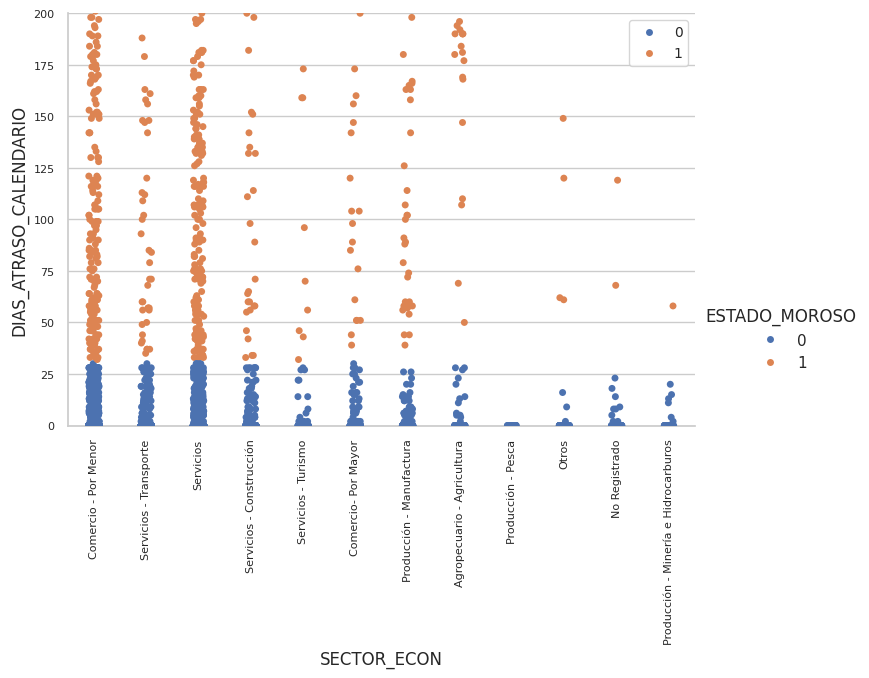

In [90]:
#Relación entre sector economico y dias de atraso
plot_catplot("SECTOR_ECON", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200 ))

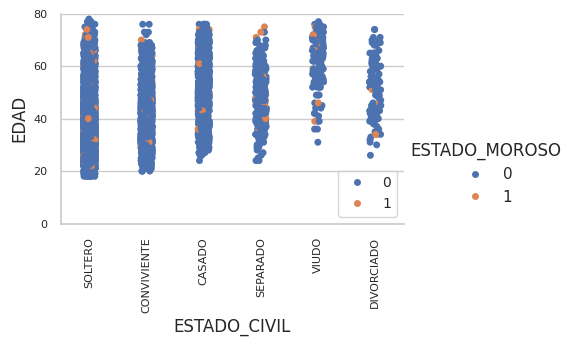

In [57]:
#Relación entre estado civil y edad
plot_catplot("ESTADO_CIVIL", "EDAD", "ESTADO_MOROSO", df, height=3, aspect=1.5, ylim=(0,80 ))

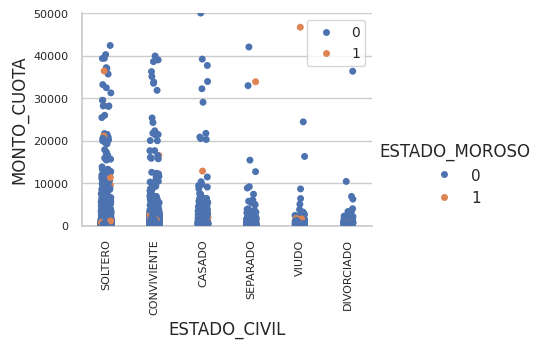

In [58]:
#Relación entre estado civil y monto de la cuota
plot_catplot("ESTADO_CIVIL", "MONTO_CUOTA", "ESTADO_MOROSO", df, height=3, aspect=1.5, ylim=(0,50000 ))

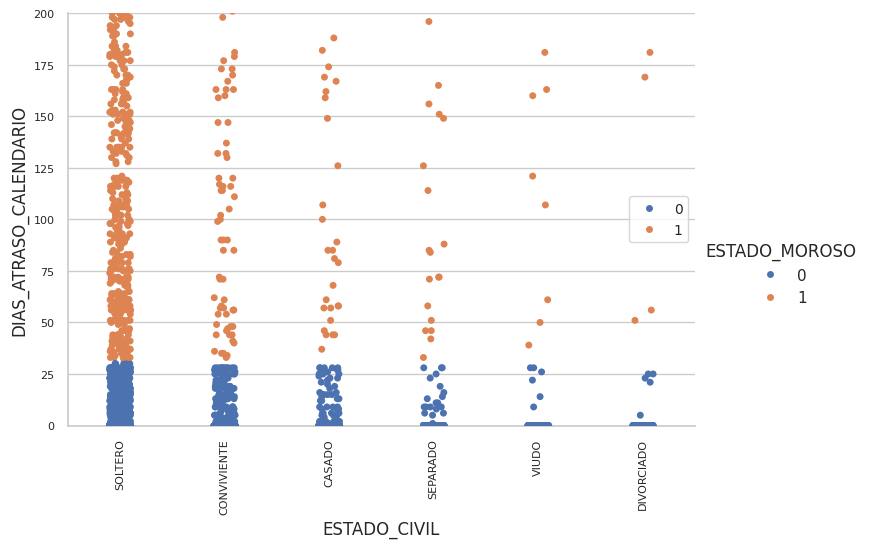

In [104]:
#Relación entre estado civil y dias de atraso
plot_catplot("ESTADO_CIVIL", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200 ))

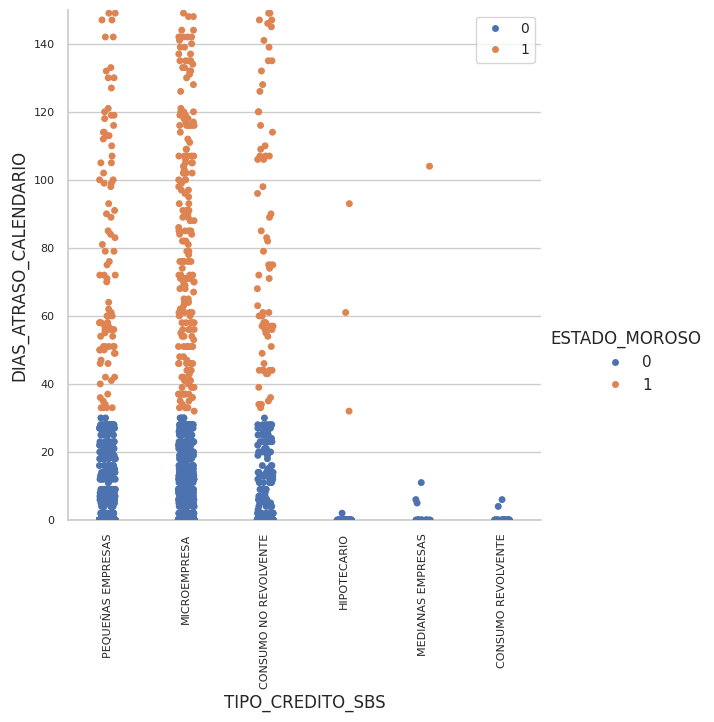

In [60]:
#Relación entre tipo de credito y dias de atraso
plot_catplot("TIPO_CREDITO_SBS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=6, aspect=1.0, ylim=(0,150))

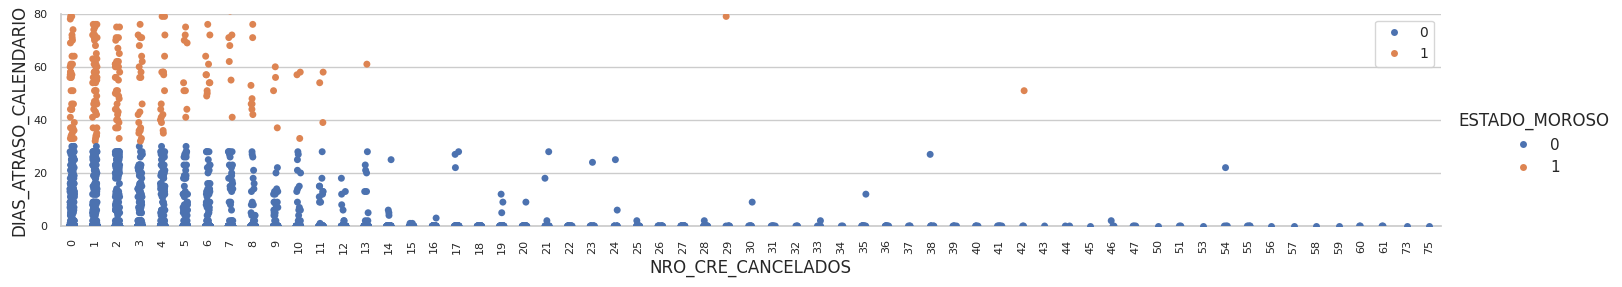

In [61]:
#Relación entre numero de creditos cancelados y dias de atraso
plot_catplot("NRO_CRE_CANCELADOS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=3, aspect=5, ylim=(0,80 ))

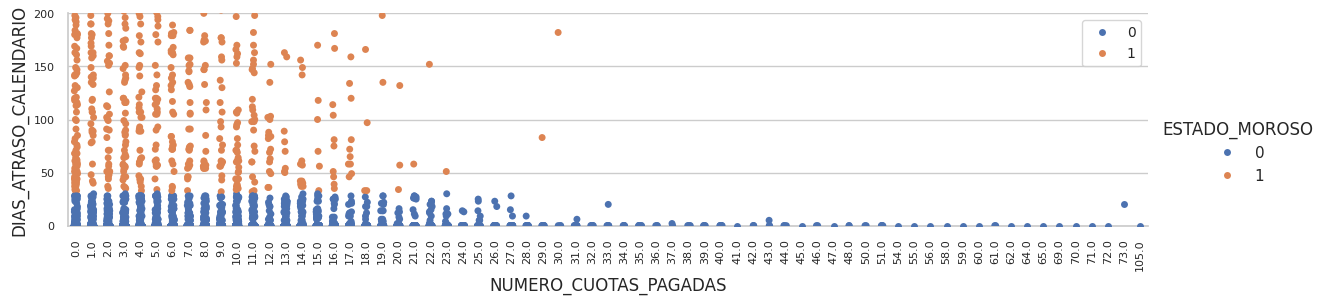

In [62]:
#Relación entre numero de cuotas pagadas y dias de atraso
plot_catplot("NUMERO_CUOTAS_PAGADAS", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=3, aspect=4, ylim=(0,200 ))

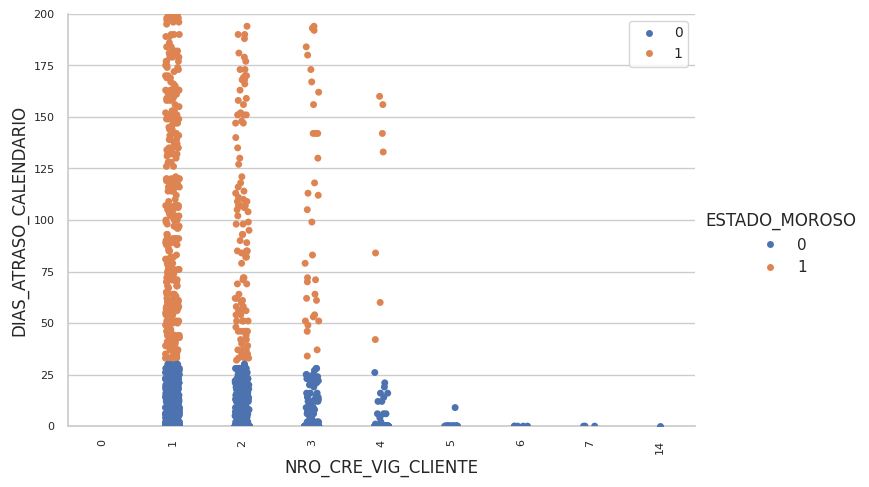

In [91]:
#Relación entre numero de creditos vigentes y dias de atraso
plot_catplot("NRO_CRE_VIG_CLIENTE", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200 ))

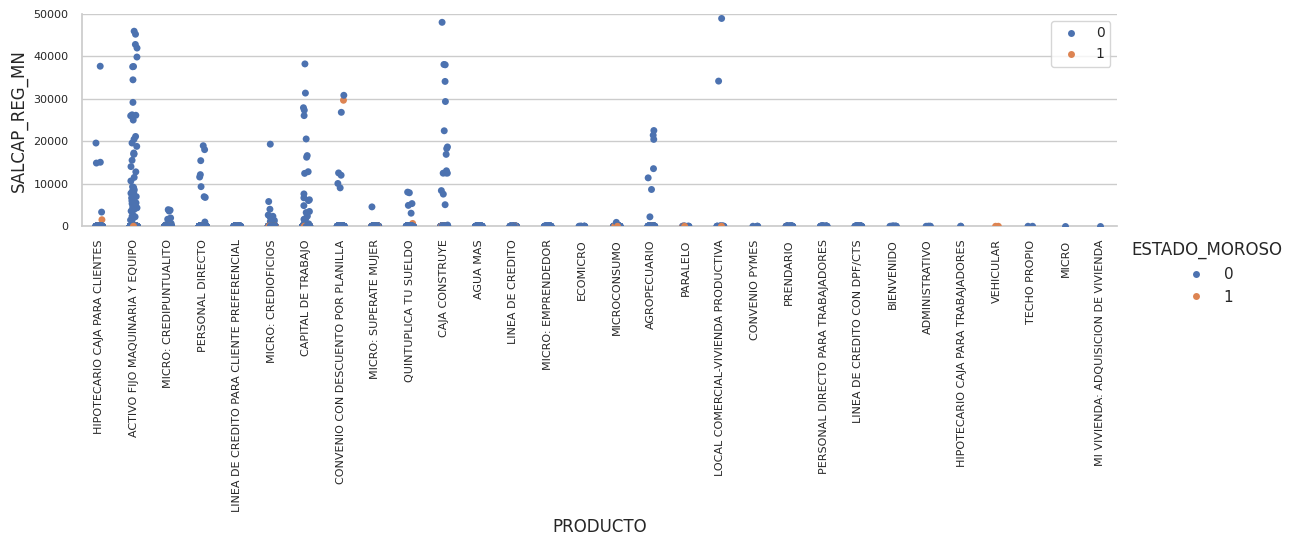

In [92]:
#Relación entre producto y el saldo capital restruturado de atraso
plot_catplot("PRODUCTO", "SALCAP_REG_MN", "ESTADO_MOROSO", df, height=3, aspect=4, ylim=(0,50000 ))


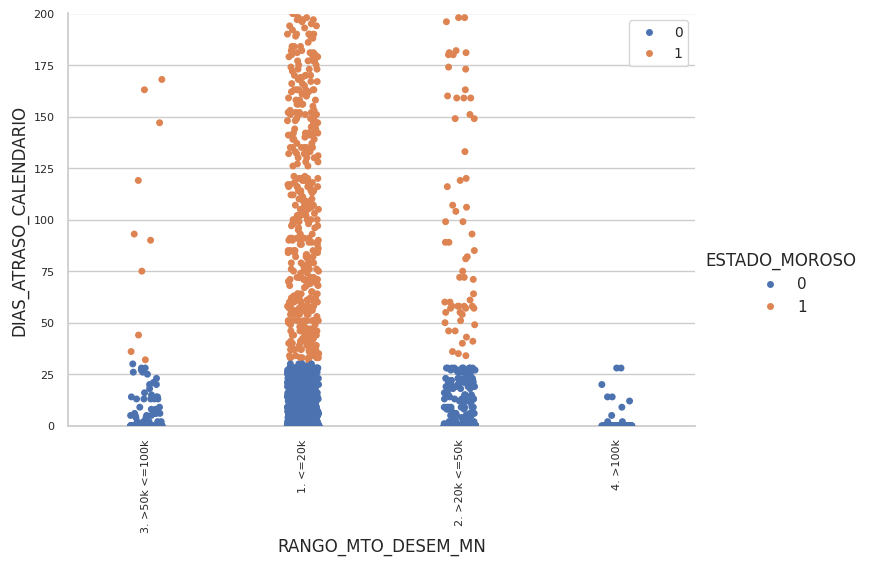

In [93]:
#Relación entre el rango de desembolso y los dias atrasados
plot_catplot("RANGO_MTO_DESEM_MN", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200))

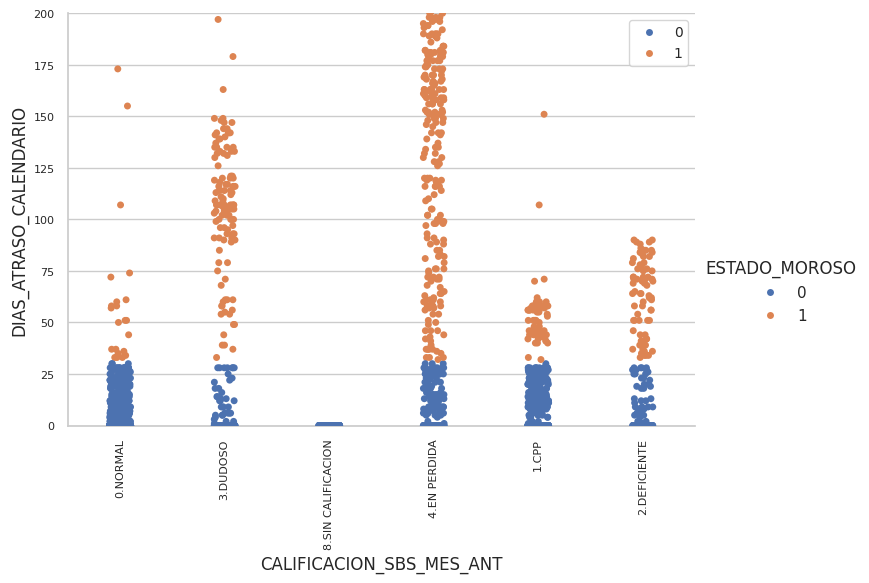

In [66]:
#Relación entre la calificacion SBS del mes anterior y los dias atrasados
plot_catplot("CALIFICACION_SBS_MES_ANT", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200))

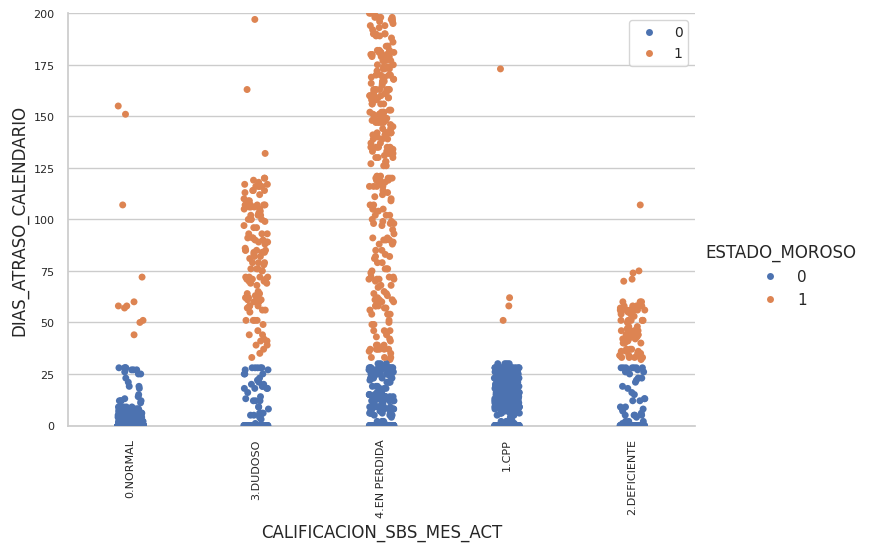

In [67]:
#Relación entre la calificacion SBS del mes actual y los dias atrasados
plot_catplot("CALIFICACION_SBS_MES_ACT", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200))

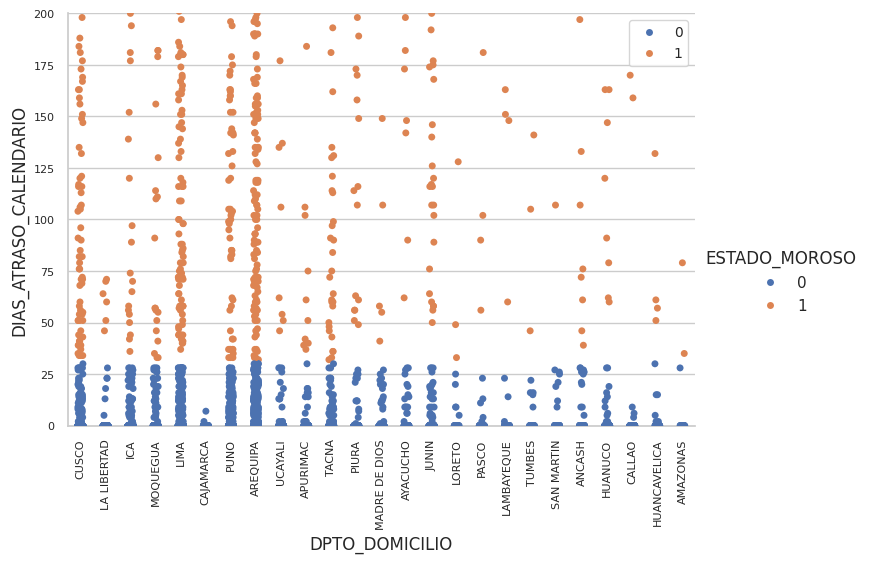

In [68]:
#Relación entre el departamento del domicilio y los dias atrasados
plot_catplot("DPTO_DOMICILIO", "DIAS_ATRASO_CALENDARIO", "ESTADO_MOROSO", df, height=5, aspect=1.5, ylim=(0,200))

In [69]:
#¿Cuales son los features numericos?
features_numericos = df.select_dtypes(include=['number']).columns.tolist()

In [70]:
# Crear listas con los features numericos 
numerico1=['SALCAP_MN', 'SALCAP_REG_MN', 'SALCAP_VEN_MN', 'SALCAP_JUD_MN', 'DIAS_ATRASO_CALENDARIO','EDAD','ESTADO_MOROSO']
numerico2 =['NRO_HIJOS','ANTIGUEDAD_MESES', 'NRO_ENTIDADES', 'MAX_NRO_ENTIDADES_ENTRE_12UM_7UM', 'MAX_DEUDA_SF_6UM','ESTADO_MOROSO']
numerico3 =['MAX_DIAS_ATRASO_12UM', 'NUMERO_TOTAL_CUOTAS', 'NUMERO_CUOTAS_PAGADAS', 'MONTO_CUOTA', 'NUMERO_CUOTAS_VENCIDAS','ESTADO_MOROSO']
numerico4=['MONTO_CUOTA', 'NUMERO_CUOTAS_VENCIDAS', 'MONTO_PAG_CAP_INT', 'DIAS_ATRASO_PAGO_ULT', 'FLAG_REPROGRAMADO','ESTADO_MOROSO']
numerico5=['NRO_REPROGRAMACIONES', 'FLAG_REFINANCIADO', 'NRO_REFINANCIACIONES', 'NRO_CRE_CANCELADOS', 'NRO_CRE_VIG_CLIENTE','ESTADO_MOROSO']
numerico6=['DIAS_ATRASO_CALENDARIO', 'ANTIGUEDAD_MESES', 'MONTO_CUOTA', 'NRO_CRE_CANCELADOS', 'NRO_CRE_VIG_CLIENTE','ESTADO_MOROSO']
numerico7 =['DIAS_ATRASO_CALENDARIO','ANTIGUEDAD_MESES', 'NRO_ENTIDADES', 'MAX_NRO_ENTIDADES_ENTRE_12UM_7UM', 'MAX_DEUDA_SF_6UM','ESTADO_MOROSO']

In [71]:
# Funcion para crear graficos scatter plots y poder encontrar posibles clusters
def kmean_pairplot(lista):
    data_full = df[lista]

    data = data_full.drop(columns=['ESTADO_MOROSO'])


    # Entrenamiento del modelo
    model = KMeans(n_clusters=2, random_state=12345)
    model.fit(data)


    # Capa extra para los centroides
    centroids = pd.DataFrame(model.cluster_centers_, columns=data.columns)


    # Trazar el gráfico
    pairgrid = sns.pairplot(data_full, hue='ESTADO_MOROSO', diag_kind='hist')
    #pairgrid.data = centroids
    pairgrid.map_offdiag(func=sns.scatterplot, s=40, color='red')

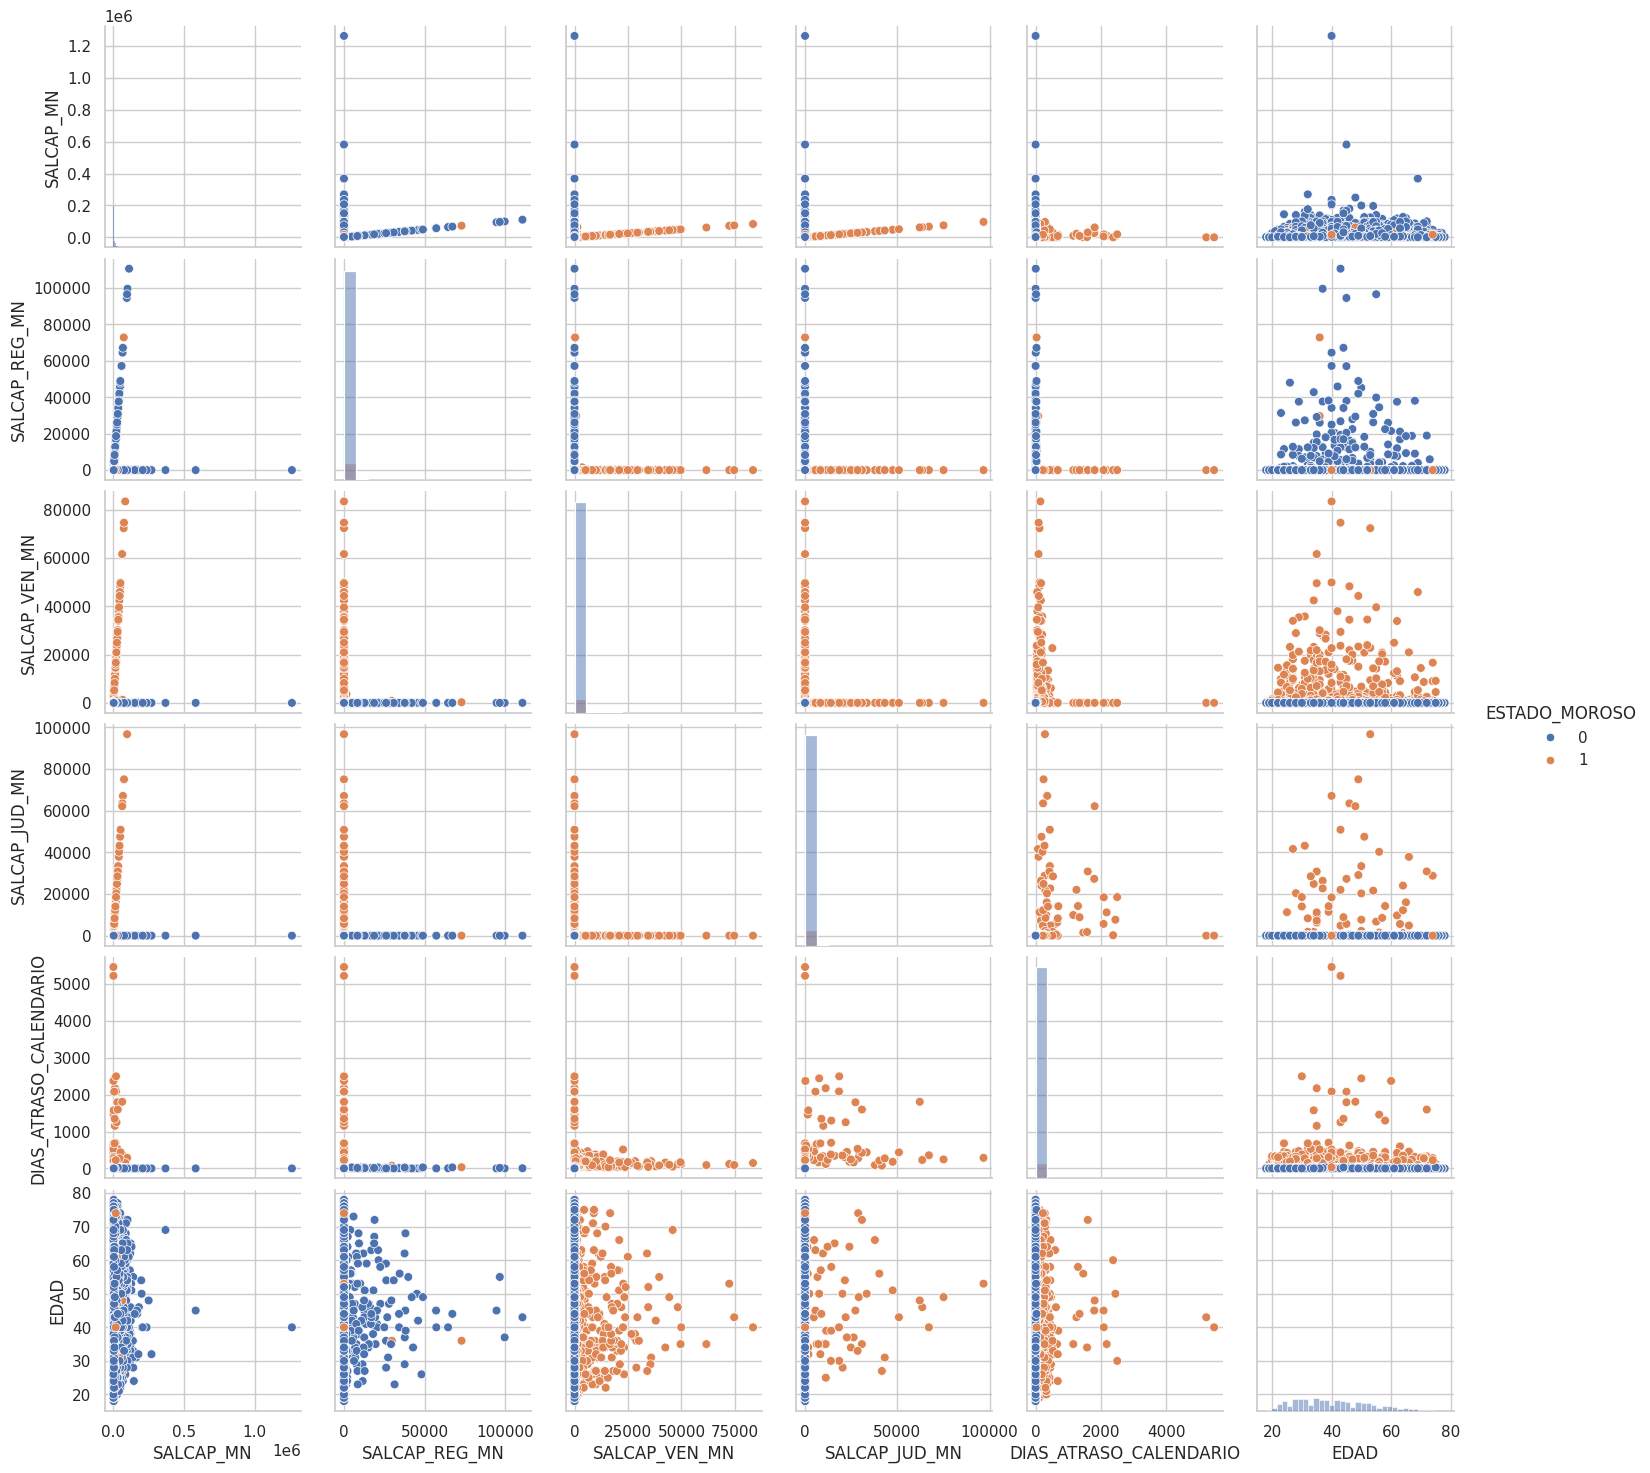

In [72]:
# LISTA 1
kmean_pairplot(numerico1)

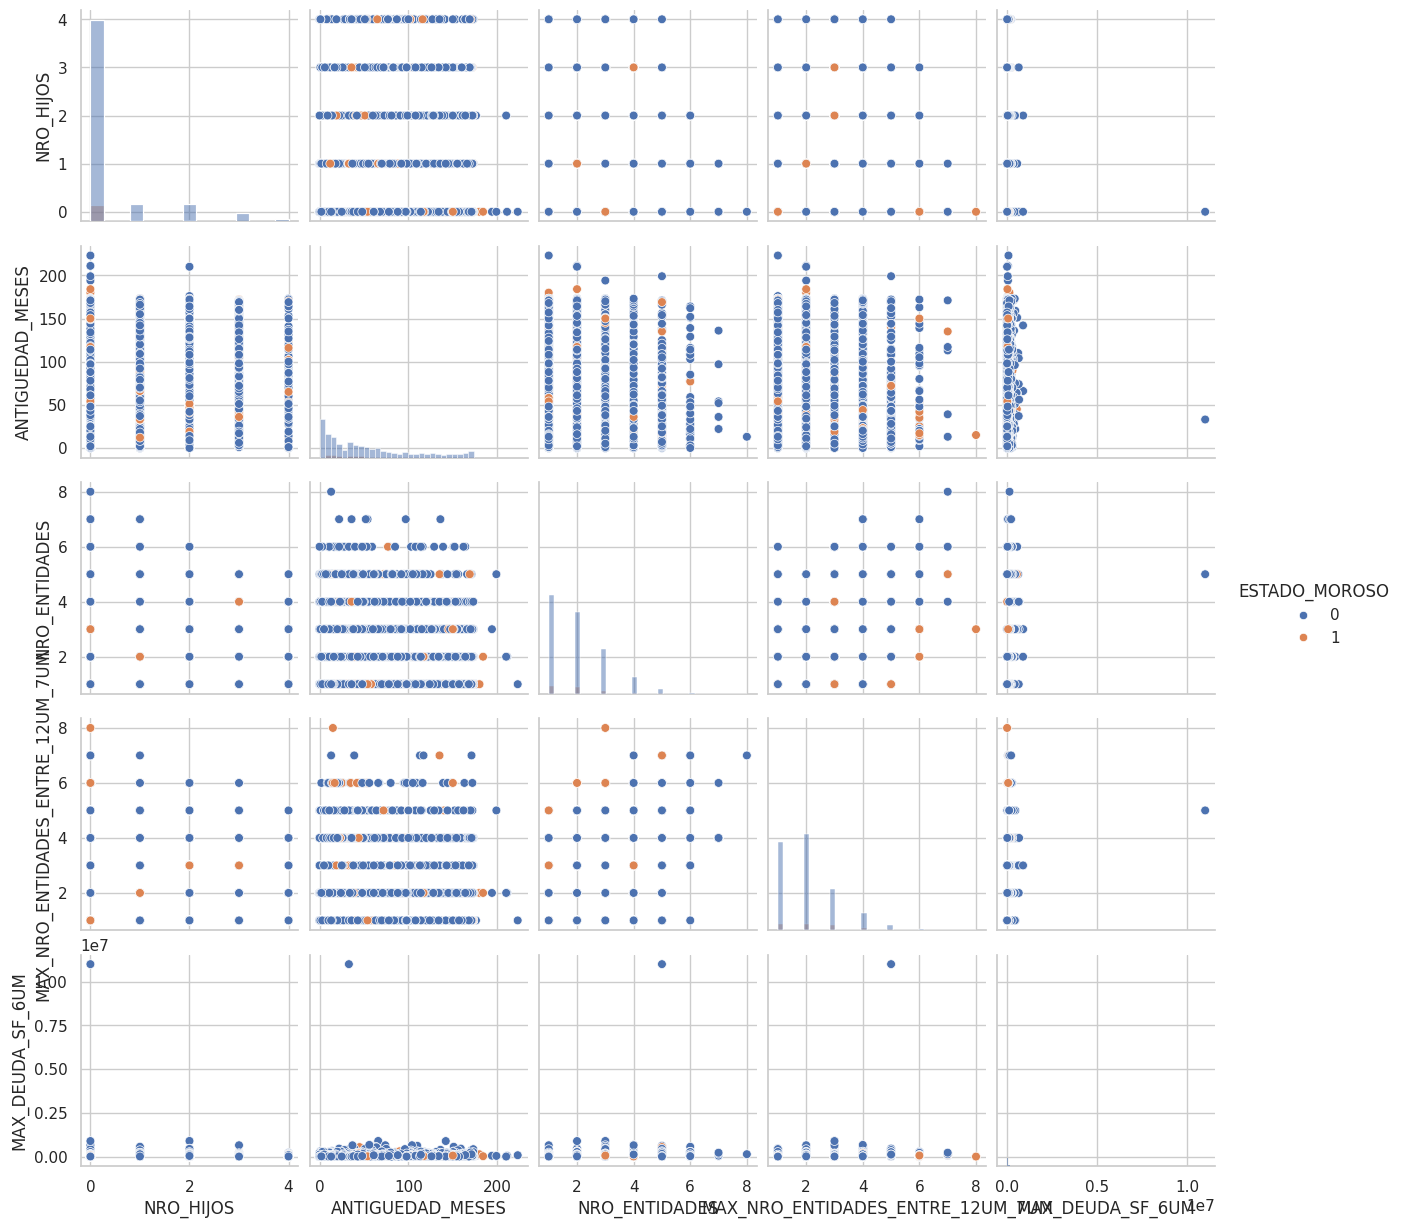

In [73]:
# LISTA 2
kmean_pairplot(numerico2)

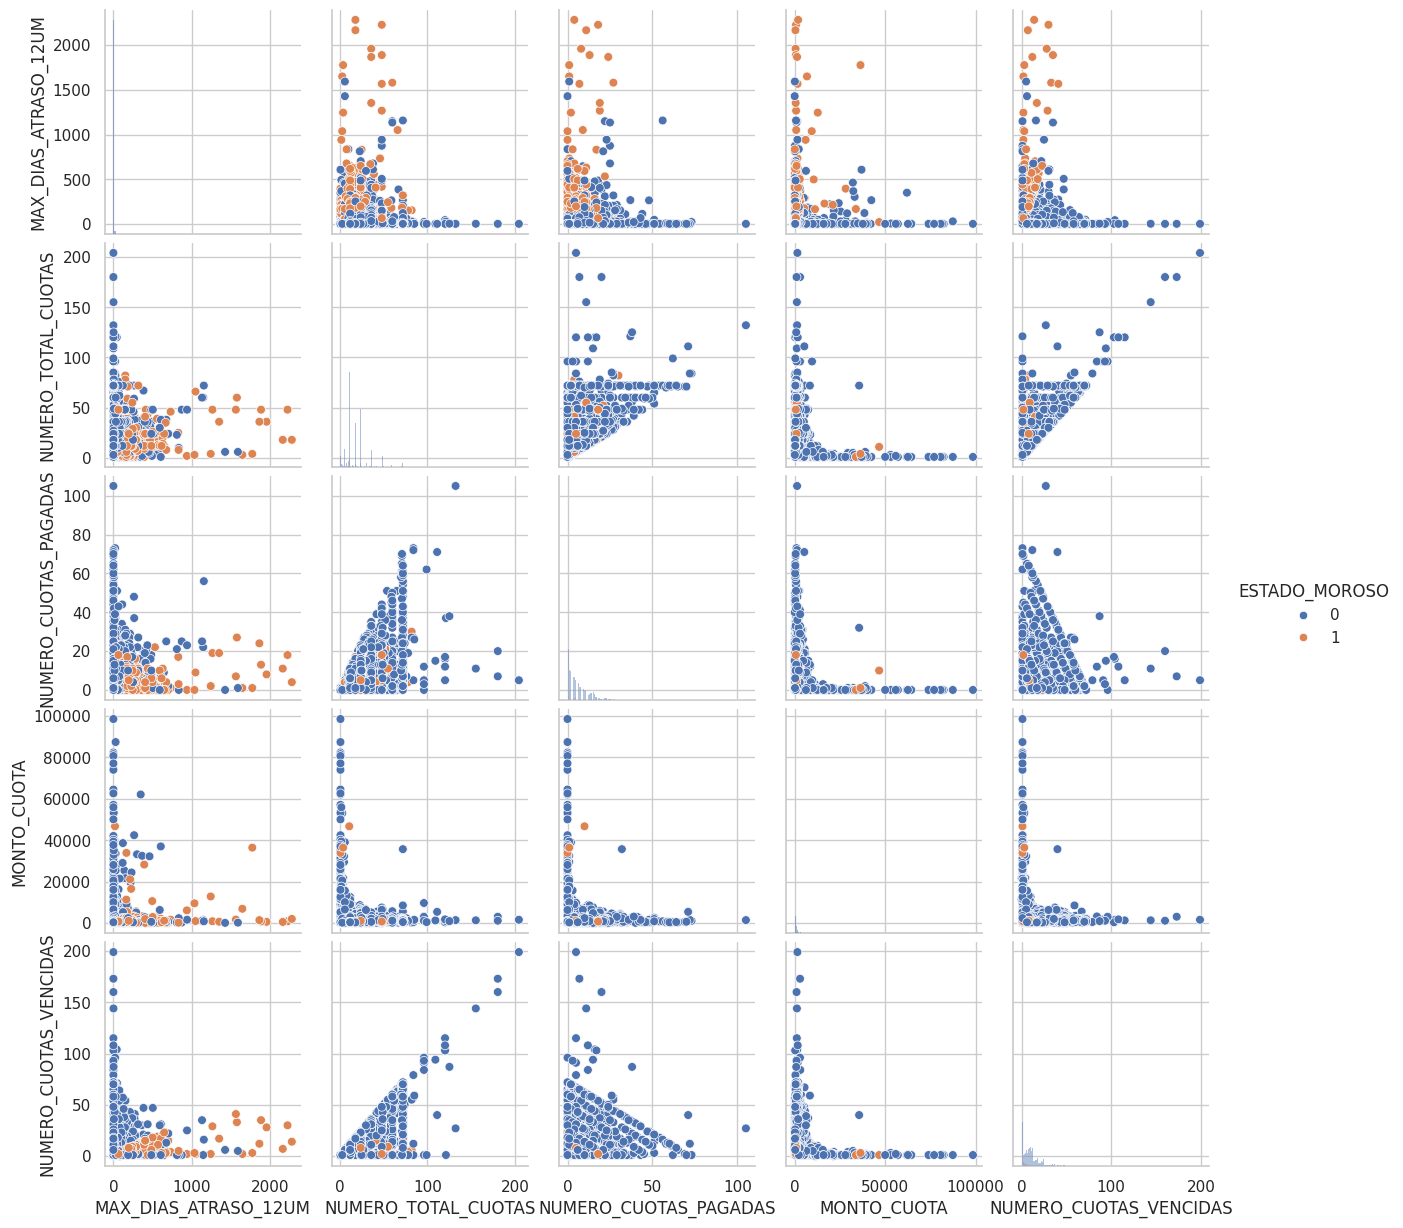

In [74]:
# LISTA 3
kmean_pairplot(numerico3)

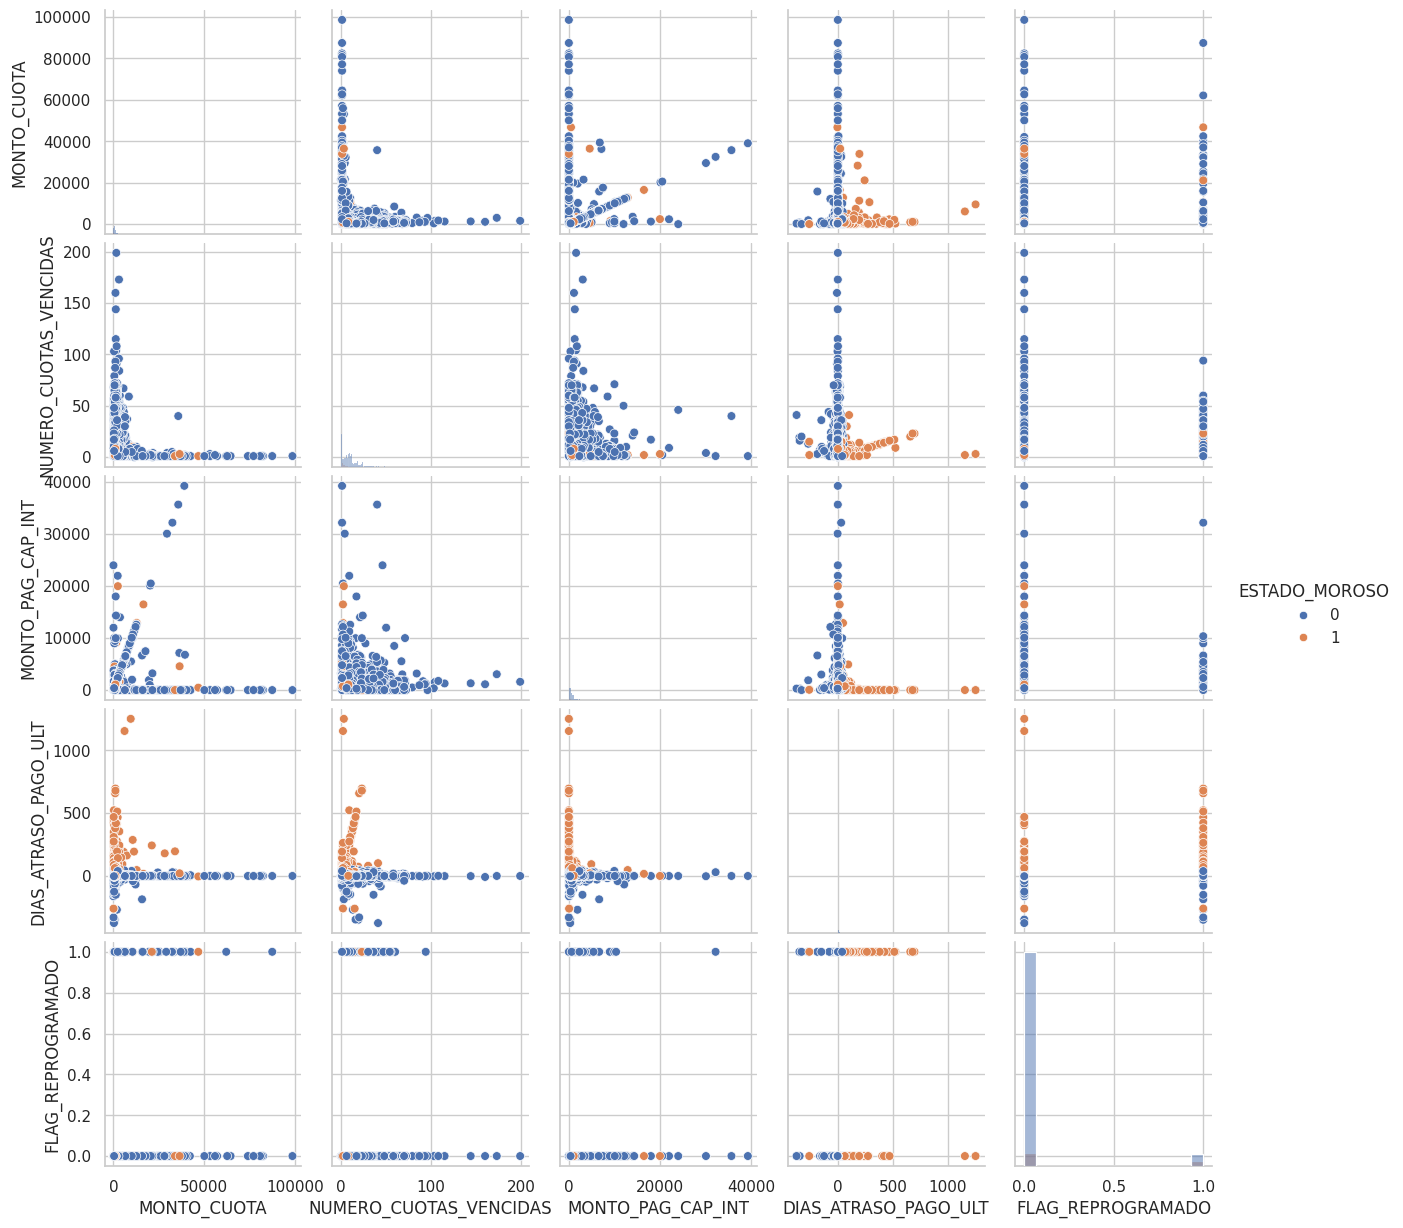

In [75]:
# LISTA 4
kmean_pairplot(numerico4)

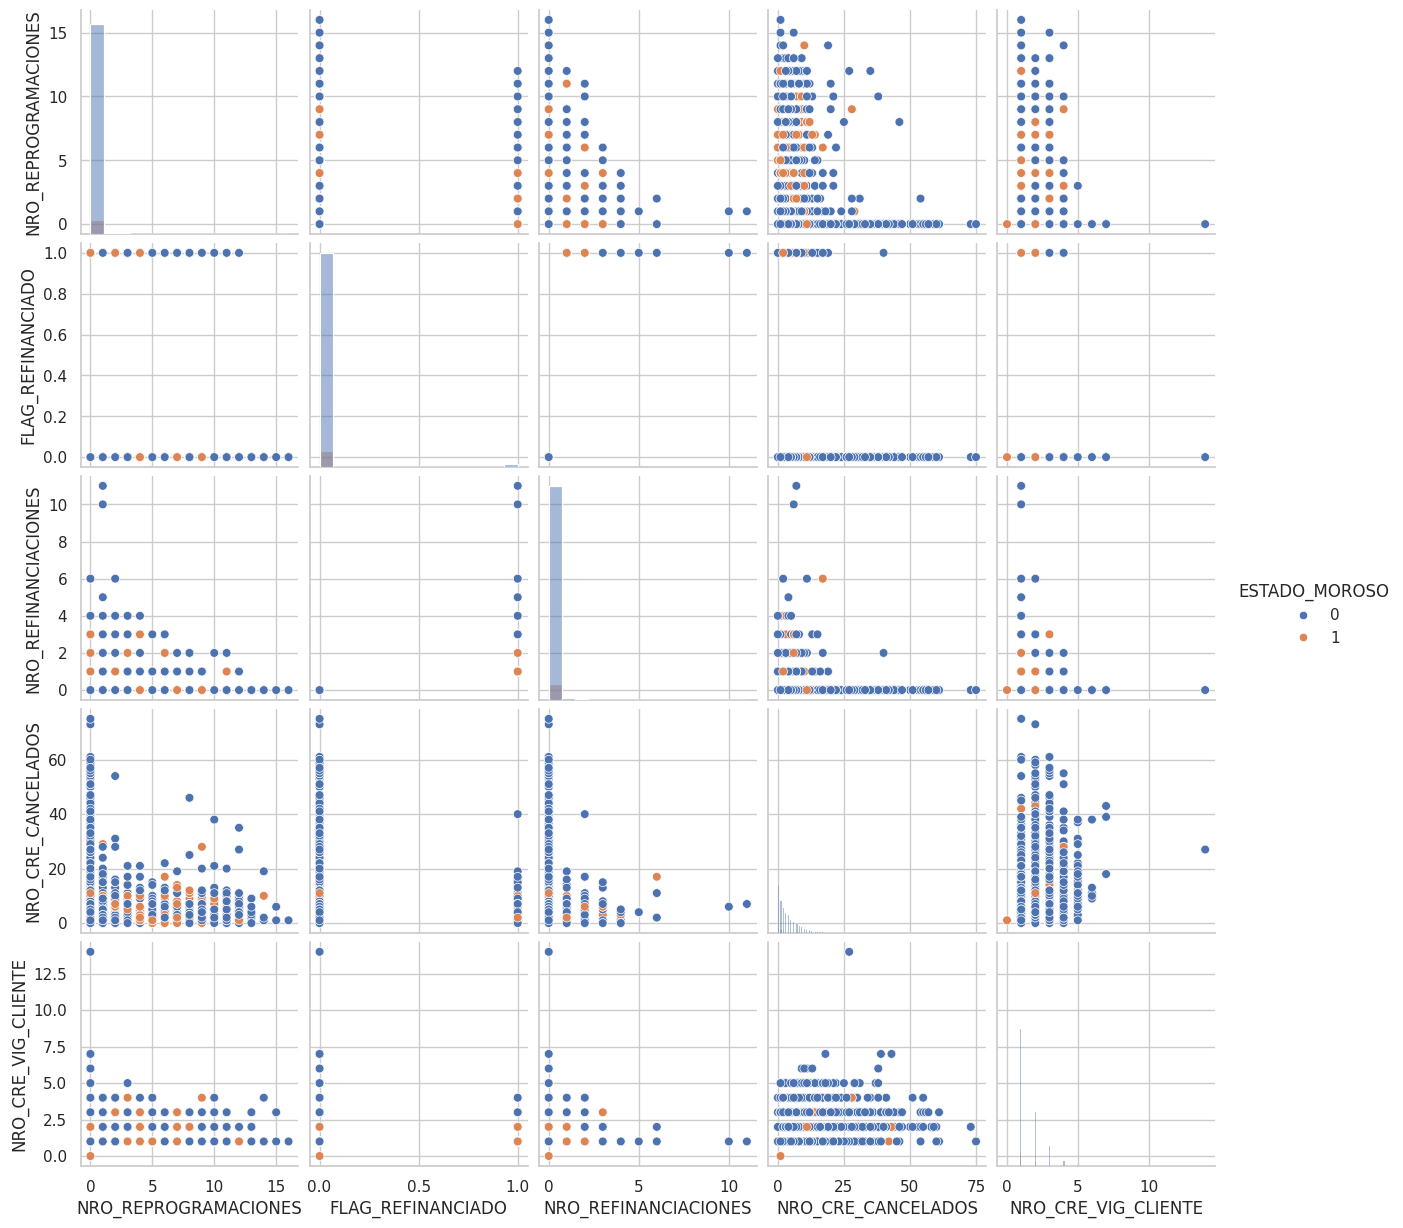

In [76]:
# LISTA 5
kmean_pairplot(numerico5)

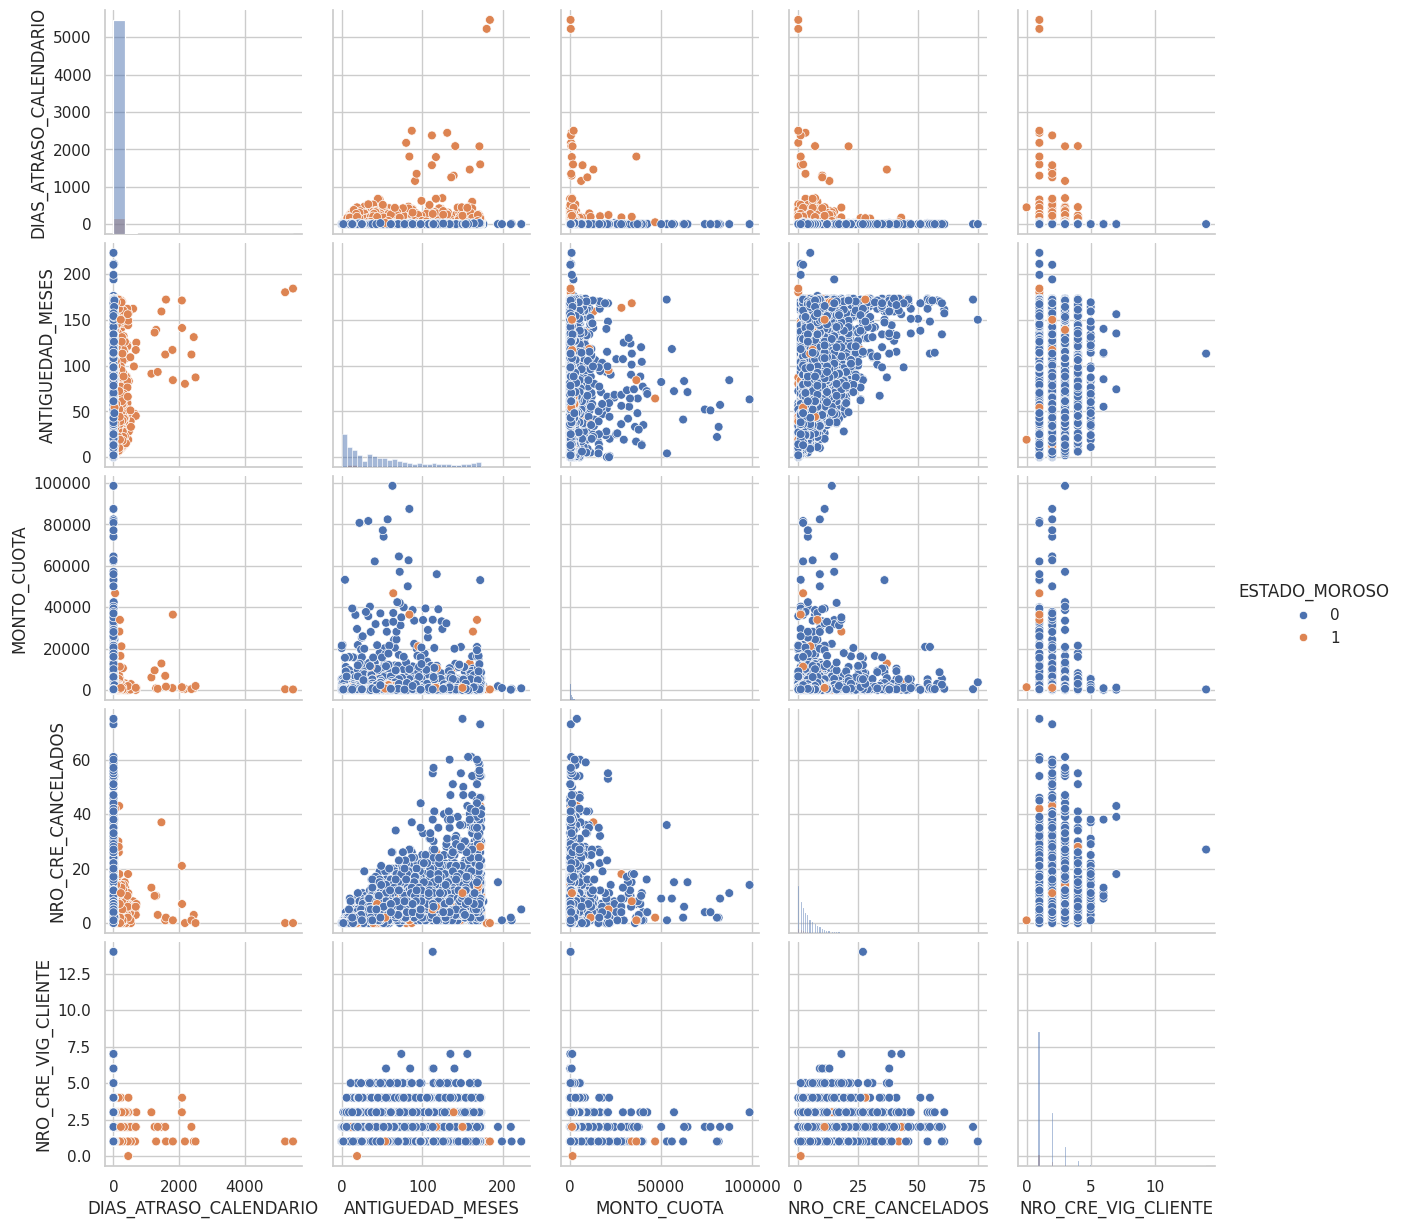

In [77]:
# LISTA 6
kmean_pairplot(numerico6)

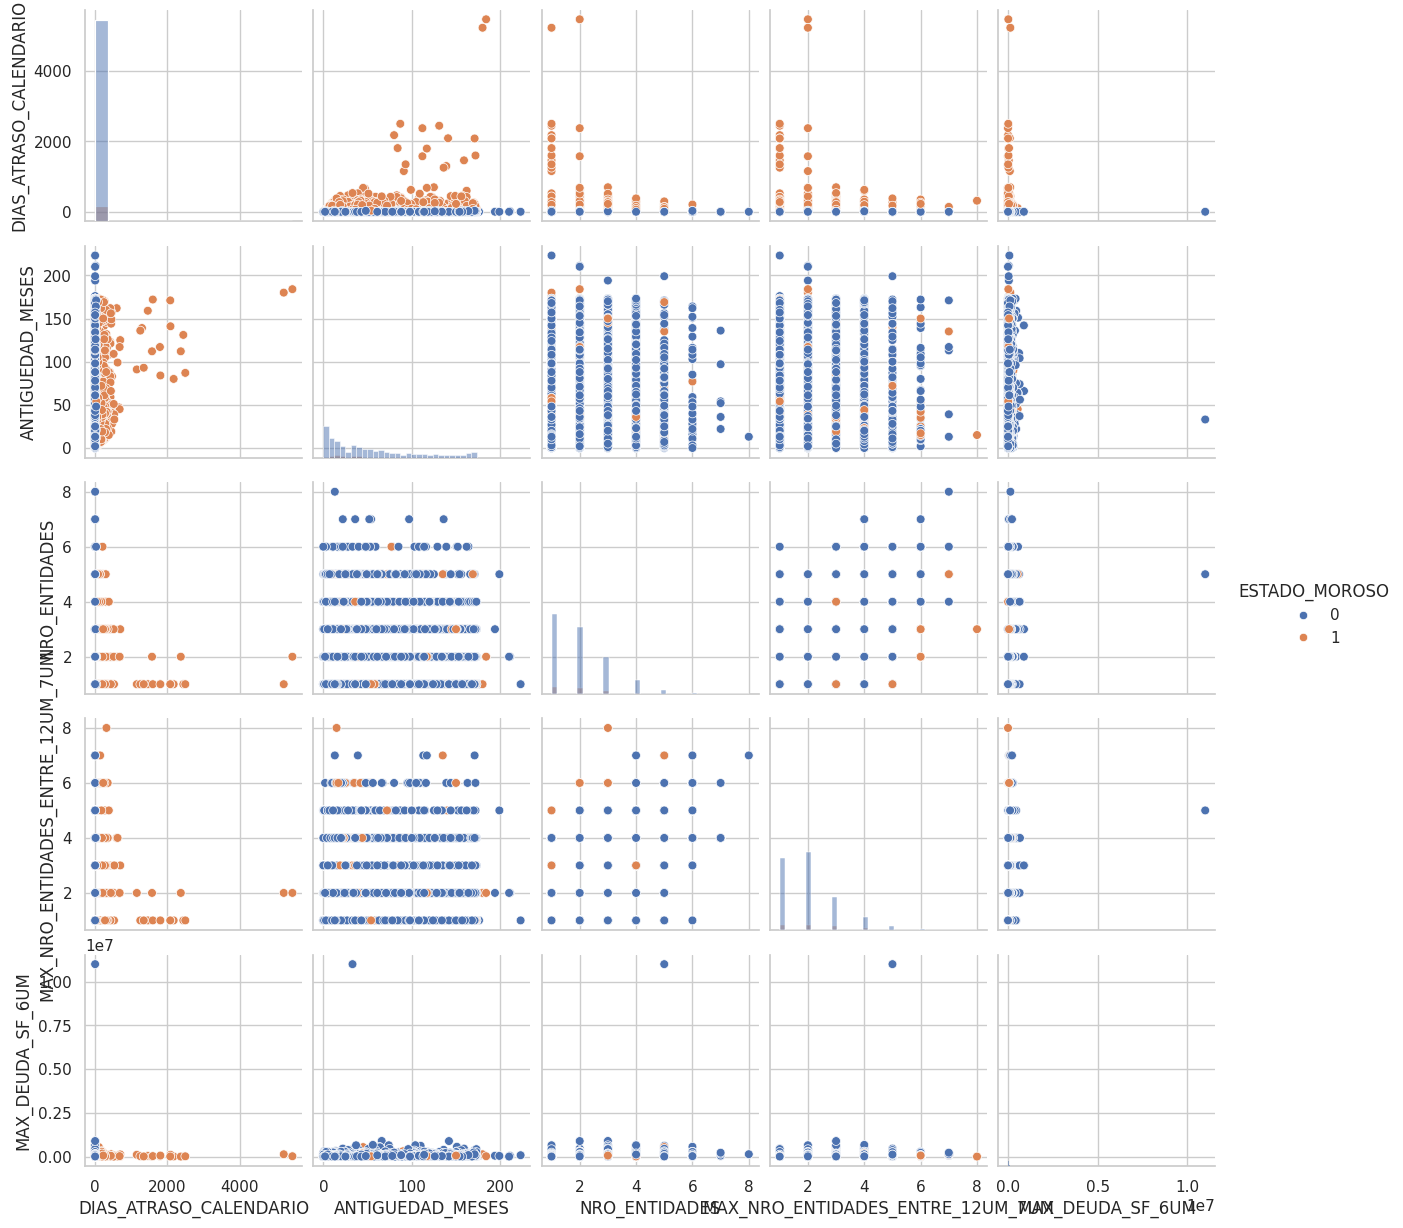

In [78]:
# LISTA 7
kmean_pairplot(numerico7)

**Hallazgos**  
1. Existe una relación muy marcada entre ESTADO_CONTABLE y DIAS_ATRASO_CALENDARIO.Cuando estado contable es igual a  1.VIGENTE o  2.REFINANCIADO los dias de atraso son <= 30.
2. VIendo el grafico entre DIAS_ATRASO_CALENDARIO y GARANTIAS, se puede ver que hay ciertas garantias que muestran muy pocos creditos morosos y hay otras que presentan bastantes.
3. En el gráfico de NRO_HIJOS vs DIAS_ATRASO_CALENDARIO, se observa que los clientes con 1 o mas hijos tienden a ser menos morosos.
4. Hay sectores economicos que muestran menos tendencia a ser clientes morosos.
5. El estado civil, segun el  grafico ESTA_CIVIL vs DIAS_ATRASO_CALENDARIO muestra que las personas solteras tienen una alta tendencia a ser morosos en comparación a otros estados civiles.


**Relaciones mas importantes:**   
6. En el grafico NRO_CRE_CANCELADOS vs DIAS_ATRASO_CALENDARIO se puede ver claramente como a partir del credito cancelado numero 10, la tendencia a la morosidad baja drasticamente, entonces un cliente con 10 o + creditos cancelados se podría considerar un cliente de confianza.    
7. De manera similar sucede en el gráfico NUMERO_CUOTAS_PAGADAS y DIAS_ATRASO_CALENDARIO, en donde se observa que apartir del numero de cuota pagada 19, la tendencia a la morosidad baja drasticamente.  
8. Se observa que en el gráfico NRO_CRE_VIG_CLIENTE y DIAS_ATRASO_CALENDARIO, si un cliente tiene 3 o mas creditos vigentes, tiene mucha menos probabilidad de ser moroso que los clientes con 2 o 1 creditos vigentes.  
9. Existe una tendencia muy alta a la morosidad cuando el rango del monto desembolsado es menor o igual a 20k soles, esto se puede verificar en la grafica RANGO_MTO_DESEM_MN vs DIAS_ATRASO_CALENDARIO.  
10. Por último, como era de esperarse la calificación del SBS del mes anterior y actual es de mucha ayuda para detectar a los morosos, segun el grafico CALIFICACION_SBS_MES_ANT vs DIAS_ATRASO_CALENDARIO, la probabilidad de que un cliente sea moroso va aumentando desde la calificacion 0:NORMAL hasta llegar a su máximo en la calificacion 4:PERDIDA.


# 6. PLUS (Entrenamiento de un modelo predictivo)

Por cuestiones de tiempo se entrenara solo un modelo en base a catboost. El objetivo es saber que cliente es propenso a ser moroso, por lo tanto es una tarea de clasificación.  
Esto permitirá poder calcular la pérdida esperada u otros asuntos relacionados.

In [79]:
# Cambiar tipo de dato para el entrenamiento
df['UBIGEO_DOMICILIO']=df['UBIGEO_DOMICILIO'].astype('str')

In [80]:
# identificar los features numericos y categoricos
features_no_numericos = df.select_dtypes(exclude=['number']).columns.tolist()
features_numericos = df.select_dtypes(include=['number']).columns.tolist()

In [81]:
# Identificar que variables categoricas podrian traer problemas
valores_unicos_categoricos = df[features_no_numericos].nunique()
valores_unicos_categoricos

ESTADO_CONTABLE             4  
PRODUCTO                    30 
TIPO_CREDITO_SBS            6  
GARANTIAS                   22 
ESTADO_CIVIL                6  
ACTIVIDAD_ECONOMICA         501
SECTOR_ECON                 12 
GENERO                      2  
SEGM_MYPE                   11 
SEGM_CNS                    6  
SEGM_MICRO                  5  
CALIFICACION_SBS_MES_ACT    5  
CALIFICACION_SBS_MES_ANT    6  
UBIGEO_DOMICILIO            621
DPTO_DOMICILIO              25 
PROV_DOMICILIO              124
DIST_DOMICILIO              586
RANGO_MTO_DESEM_MN          4  
dtype: int64

In [82]:
# Crear un dataframe para poder entrenar un modelo 
# eliminaré las variables que pueden aportar ruido 
df_modelo = df.drop(['ACTIVIDAD_ECONOMICA','UBIGEO_DOMICILIO','DIST_DOMICILIO','PROV_DOMICILIO'],axis=1)

# Tamebien eliminaré ESTADO_CONTABLE y DIAS_ATRASO_CALENDARIO ya que esta muy relacionado al target (ESTADO_MOROSO)
df_modelo = df_modelo.drop(['ESTADO_CONTABLE','DIAS_ATRASO_CALENDARIO','CALIFICACION_SBS_MES_ACT'],axis=1)

In [83]:
features_no_numericos = df_modelo.select_dtypes(exclude=['number']).columns.tolist()
features_numericos = df_modelo.select_dtypes(include=['number']).columns.tolist()

In [84]:
# Separar el datase en target y feature
target= df_modelo['ESTADO_MOROSO']
features = df_modelo.drop(['ESTADO_MOROSO'],axis=1)

In [85]:
# Separar el dataset en entrenamiento y prueba
features_train, features_valid, target_train, target_valid = train_test_split(
                    features, target, test_size=0.25, random_state=12345)

In [86]:
# Define un diccionario de hiperparámetros que deseas ajustar
param_grid = {
    'iterations': [150,300,400],  # Número de iteraciones (árboles)
    'depth': [6,7,8],  # Profundidad máxima de los árboles
    'learning_rate': [0.01,0.1],  # Tasa de aprendizaje
}

# Crea un modelo de CatBoostRegressor
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=12345,
                              cat_features=features_no_numericos, early_stopping_rounds=30, verbose=0)  

# Crea un objeto GridSearchCV con el modelo y el diccionario de hiperparámetros
grid_search3 = GridSearchCV(estimator=catboost, param_grid=param_grid, scoring='roc_auc', cv=None)  


# Ajusta el modelo a tus datos de entrenamiento
grid_search3.fit(features_train, target_train)

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search3.best_params_)
print()

# Obtén el mejor modelo entrenado
best_catboost_model = grid_search3.best_estimator_

###############################################################

# Hacer predicciones en el conjunto de validación
predicted_probs = best_catboost_model.predict_proba(features_train)[:, 1]
prediccion = best_catboost_model.predict(features_train)

# Calcular el AUC-ROC en el conjunto de validación
auc_roc = roc_auc_score(target_train, predicted_probs)
accuracy = accuracy_score(target_train, prediccion)
f1 = f1_score(target_train, prediccion)

print('Métricas para el dataset de entrenamiento')
print('auc_roc train:',auc_roc)
print('accuracy train:',accuracy )
print('f1 train:',f1 )
print()

##########################################################################
# Hacer predicciones en el conjunto de validación
predicted_probs = best_catboost_model.predict_proba(features_valid)[:, 1]
prediccion = best_catboost_model.predict(features_valid)
# Calcular el AUC-ROC en el conjunto de validación
auc_roc = roc_auc_score(target_valid, predicted_probs)
accuracy = accuracy_score(target_valid, prediccion)
f1 = f1_score(target_valid, prediccion)
print('Métricas para el dataset de validación')
print('auc_roc valid:',auc_roc)
print('accuracy valid:',accuracy )
print('f1 valid:',f1 )

Mejores hiperparámetros: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}

Métricas para el dataset de entrenamiento
auc_roc train: 1.0
accuracy train: 1.0
f1 train: 1.0

Métricas para el dataset de validación
auc_roc valid: 0.9971957190176439
accuracy valid: 0.9995939910678034
f1 valid: 0.9975062344139651


**Resultado del modelo predictivo**  
Tanto las metricas del modelo para el dataset de entrenamiento como para el dataset de validación han salido bastante bien. Lo que indica que este modelo podrá clasificar de manera precisa a los clientes.

In [103]:
df['ESTADO_MOROSO'].value_counts()

0    9117
1    733 
Name: ESTADO_MOROSO, dtype: int64